# **Underwater Image Enhancement with Reinforcement Learning**


# Problem Description


The problem of Underwater Image Enhancement concerns the improvement of underwater images and is attracting a lot of attention due to its importance in naval engineering and aquatic robotics. It is a challenging task due to a series of problems caused by the environment in which such photos are taken.

The main problems are caused by two phenomena: **scattering**, which is the presence of particles such as dust and plankton, and **absorption**, the absorption due to the wavelength that alters the color of the image making it darker and changing its dominant color.


# Library Imports


In [1]:
#force package installation 
!pip install split-folders

In this section, the necessary modules are imported.
 
Specifically, the library
**OpenAI**
[**Gym**](https://www.gymlibrary.ml/), a toolkit developed by the company [**OpenAI**](https://openai.com/), provides an artificial intelligence benchmark that is easy to set up with a wide variety of different environments for developing and comparing reinforcement learning algorithms.


In [2]:
import os

# Suppress TensorFlow logging when running the notebook on a cluster to avoid clutter.
"""
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
"""

from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import (
    decode_predictions,
    preprocess_input,
)  # Preprocess numpy tensors for VGG19 model input.
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import (
    categorical_crossentropy,
    MeanAbsoluteError,
    MeanSquaredError,
)
from tensorflow.keras.models import (
    Model,
)  # Allows feature extraction from any layer of a VGG model.
from tensorflow.keras.utils import get_file, load_img, plot_model

import numpy as np
import glob
import cv2 as cv
import time  # Used to measure training and step durations.

from matplotlib import pyplot as plt
from skimage.metrics import (
    structural_similarity,
    peak_signal_noise_ratio,
    mean_squared_error,
)
from statistics import mean
from random import (
    sample,
    randrange,
)  # Sampling for DDQN memory and random action selection.
from splitfolders import ratio as splitfolders_ratio
from shutil import rmtree
from imgaug import augmenters as iaa  # Image augmentation for sharpening and embossing.
from itertools import combinations_with_replacement
from collections import defaultdict
from PIL import ImageEnhance, Image
from IPython.display import (
    clear_output,
)  # Clear cell output to maintain notebook readability.

from gym import Env  # Base class for creating custom environments.
from gym.spaces import Box, Discrete

#Utility functions


Some utility functions are defined.
The most important ones are:

- `plot_training_rewards` plots the trend of the total reward and its moving average achieved during the different episodes of the training process.
  * `rewards`: vector of rewards to plot
  * `moving_avg_window_size`: number of consecutive episodes considered in calculating the moving average of the total reward

- `show_image_grid` allows printing a configurable grid of random images sampled from a source folder
  * `image_path`: path of the folder from which to sample images to display
  * `grid_size`: a pair of values that defines the dimensions of the grid in terms of the number of images on each axis
  * `image_size`: size of the images on the grid

- `compare_images` prints multiple side-by-side images, accompanied by titles
  * `images`: vector of images to show
  * `titles`: vector of image titles, useful for making the printout readable
  * `image_size`: display size of the images

- `display_image` allows printing an image
  * `image`: image to display


In [3]:
def plot_training_rewards(rewards, moving_avg_window_size=None):
    """
    Plot the training rewards and optionally their moving average over episodes.

    Args:
        rewards (list): List of rewards obtained per episode.
        moving_avg_window_size (int, optional): The window size for calculating the moving average. Defaults to None.

    Plots:
        Line plot of rewards and their moving average (if specified) against episodes.
    """
    if moving_avg_window_size is not None:
        moving_avg_total_reward = []
        for i in range(len(rewards)):
            window = rewards[max(0, i - moving_avg_window_size + 1) : i + 1]
            window_avg = mean(window)
            moving_avg_total_reward.append(window_avg)

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(range(len(rewards)), rewards, label="Total reward", color="orange")
    ax.set_xlabel("Episodes")
    if moving_avg_window_size is not None:
        ax.plot(
            range(len(moving_avg_total_reward)),
            moving_avg_total_reward,
            label="Total reward moving average",
        )
        ax.legend(loc="upper left")


def show_image_grid(image_path, grid_size, image_size):
    """
    Display a grid of images randomly sampled from a specified directory.

    Args:
        image_path (str): Path to the directory containing images.
        grid_size (tuple): The dimensions (rows, columns) of the image grid.
        image_size (tuple): Size of each image in the grid.

    Displays:
        A grid of images.
    """
    fig = plt.figure(figsize=image_size)
    rows, columns = grid_size
    for i in range(1, columns * rows + 1):
        fn = np.random.choice(image_path)
        img = Image.open(fn)
        fig.add_subplot(rows, columns, i)
        plt.axis("off")
        plt.imshow(img)
    plt.show()


def compare_images(images, titles, image_size):
    """
    Compare multiple images side by side with titles.

    Args:
        images (list): List of images to display.
        titles (list): Corresponding titles for the images.
        image_size (tuple): Size of the display for the images.

    Displays:
        Images side by side for comparison.
    """
    number_of_images = len(images)
    fig, axes = plt.subplots(1, number_of_images, figsize=image_size)
    for i in range(number_of_images):
        axes[i].imshow(images[i])
        axes[i].set_title(titles[i])
        axes[i].axis("off")
    plt.show()


def display_image(image) -> None:
    """
    Display an image.

    Args:
        image (PIL.Image.Image): Image object to display.

    Displays:
        The image.
    """
    plt.figure()
    plt.imshow(image)

# Dataset


The following [**dataset**](https://li-chongyi.github.io/proj_benchmark.html) contains 890 raw images (**raw images**) with corresponding high-quality reference images (**reference images**).
It also includes 60 images without a corresponding reference, defined as **challenge images**.

In recent years, numerous algorithms have been proposed for the problem of Underwater Image Enhancement. However, these are often evaluated using synthetic datasets or a few selected images from the real world. It is therefore not very clear how these algorithms would perform on images captured in nature and how progress in the field could be measured. To address this gap, it was decided to use this dataset containing large-scale real-world images. This allows for a comprehensive study of underwater image enhancement algorithms.


In [4]:
# Path to the directory containing the original underwater dataset
dataset_path = "underwater_dataset"
# Path to the directory where the dataset will be stored after splitting into training, validation, and test sets
splitted_dataset_path = "splitted_dataset"

## Splitting


The dataset is divided into three sets: training, validation, and test set. Training sessions are conducted on the **training set**, adjusting hyperparameters to achieve different models with varying performances. Among these models, the one that achieves the best performance on the **validation set** is selected, evaluated against the chosen metrics. Finally, performance analysis is conducted using the selected model on the **test set**.

`split_dataset` is the function used to divide the dataset into training set, validation set, and test set (sizes are expressed in tenths: e.g., 0.2 corresponds to 20% of the total)
  * `training_set_size`: size of the training set
  * `test_set_size`: size of the test set
  * `validation_set_size`: size of the validation set

The `splitfolder` library is used to partition the dataset and achieve the following folder hierarchy:

* /content/splitted_dataset
  * /train
    * /raw-890
    * /reference-890
  * /test
    * /raw-890
    * /reference-890
  * /val
    * /raw-890
    * /reference-890

In [5]:
def split_dataset(training_set_size, test_set_size, validation_set_size):
    """
    Splits the dataset into training, test, and validation sets based on the provided sizes.

    Args:
    training_set_size (float): Proportion of the dataset to be used as the training set.
    test_set_size (float): Proportion of the dataset to be used as the test set.
    validation_set_size (float): Proportion of the dataset to be used as the validation set.

    The function first checks if the directory for the split dataset exists. If it does, it removes it.
    Then, it uses the `splitfolders_ratio` function from the `splitfolders` library to split the dataset
    into the specified proportions and saves them in the designated output directory.
    """
    # Check if the split dataset directory exists and remove it if it does
    if os.path.isdir(splitted_dataset_path):
        rmtree(splitted_dataset_path)

    # Split the dataset into training, test, and validation sets and save to the specified directory
    splitfolders_ratio(
        dataset_path,
        output=splitted_dataset_path,
        ratio=(training_set_size, test_set_size, validation_set_size),
    )

    # Uncomment the following line if the original dataset directory should be removed after splitting
    # rmtree(dataset_path)

The table below shows the data related to the division made for the experiment:

set             | percentage | number of images
---             | ---        | ---
Training set    | 60%        | 534
Test set        | 20%        | 178
Validation set  | 20%        | 178
**total**       | **100%**   | **890**


In [6]:
# Define the proportions for the dataset splits
training_set_size = 0.6  # 60% of the dataset for training
test_set_size = 0.2  # 20% of the dataset for testing
validation_set_size = 0.2  # 20% of the dataset for validation

# Call the function to split the dataset according to the defined proportions
split_dataset(training_set_size, test_set_size, validation_set_size)

Copying files: 1840 files [00:05, 334.18 files/s]


## Analysis


In [7]:
# This section sorts and stores image paths from different dataset splits into utility variables.
# It also prints the count of images in each category for verification purposes.

# Using glob to find all pathnames matching a specified pattern and sorting them by filename length.
images_raw = sorted(glob.glob(dataset_path + "/raw-890/*.png"), key=len)
images_ref = sorted(glob.glob(dataset_path + "/reference-890/*.png"), key=len)

# Display the total number of raw and reference images.
print("Total number of raw images: ", len(images_raw))
print("Total number of reference images: ", len(images_ref))

# Sorting and storing paths of raw images from training, testing, and validation splits.
images_raw_train = sorted(
    glob.glob(splitted_dataset_path + "/train/raw-890/*.png"), key=len
)
images_raw_test = sorted(
    glob.glob(splitted_dataset_path + "/test/raw-890/*.png"), key=len
)
images_raw_val = sorted(
    glob.glob(splitted_dataset_path + "/val/raw-890/*.png"), key=len
)

# Display the counts of raw images in each dataset split.
print("Total number of raw images for training: ", len(images_raw_train))
print("Total number of raw images for validation: ", len(images_raw_val))
print("Total number of raw images for testing: ", len(images_raw_test))

# Sorting and storing paths of reference images from training, testing, and validation splits.
images_ref_train = sorted(
    glob.glob(splitted_dataset_path + "/train/reference-890/*.png"), key=len
)
images_ref_test = sorted(
    glob.glob(splitted_dataset_path + "/test/reference-890/*.png"), key=len
)
images_ref_val = sorted(
    glob.glob(splitted_dataset_path + "/val/reference-890/*.png"), key=len
)

# Display the counts of reference images in each dataset split.
print("Total number of reference images for training: ", len(images_ref_train))
print("Total number of reference images for validation: ", len(images_ref_val))
print("Total number of reference images for testing: ", len(images_ref_test))

Total number of raw images:  890
Total number of reference images:  890
Total number of raw images for training:  534
Total number of raw images for validation:  178
Total number of raw images for testing:  178
Total number of reference images for training:  534
Total number of reference images for validation:  178
Total number of reference images for testing:  178


`sample_images` is a function used to sample a raw image and its reference from the selected set (training, test, or validation)
  * `source` indicates the set from which to sample the image, "test" for the test set, "val" for the validation set, and any other value for the training set
  * `target_size` defines the image size; if omitted, the original size is used


In [8]:
def sample_images(source="train", target_size=None):
    """
    Randomly samples a raw image and its corresponding reference image from a specified dataset split.

    Args:
    source (str): The dataset split from which to sample the images. Options are "train", "test", or "val".
                  Default is "train".
    target_size (tuple): The desired size of the output images as (width, height). If None, images are loaded in their original size.

    Returns:
    tuple: A tuple containing two elements:
           - raw_img: The sampled raw image.
           - ref_img: The sampled reference image.
    """
    # Choose the appropriate dataset split based on the source argument
    if source == "test":
        random_img_path = np.random.choice(images_raw_test)
    elif source == "val":
        random_img_path = np.random.choice(images_raw_val)
    else:
        random_img_path = np.random.choice(images_raw_train)

    # Extract the filename from the path
    random_img = random_img_path.split("/")[-1]

    # Construct the full path for the raw image and load it
    file_raw = f"{splitted_dataset_path}/{source}/raw-890/{random_img}"
    raw_img = load_img(path=file_raw, target_size=target_size)

    # Construct the full path for the reference image and load it
    file_ref = f"{splitted_dataset_path}/{source}/reference-890/{random_img}"
    ref_img = load_img(path=file_ref, target_size=target_size)

    return raw_img, ref_img

As an example, some raw images randomly sampled from the dataset are displayed. Subsequently, given a randomly chosen raw image, the reference image associated with it is also displayed, in order to perform a visual comparison.


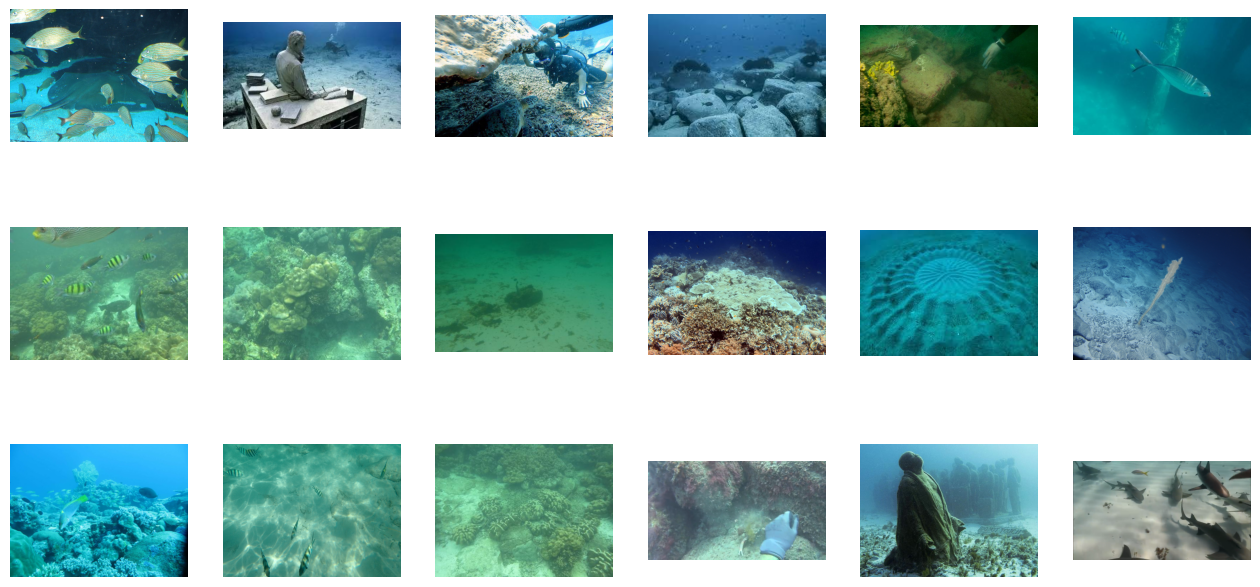

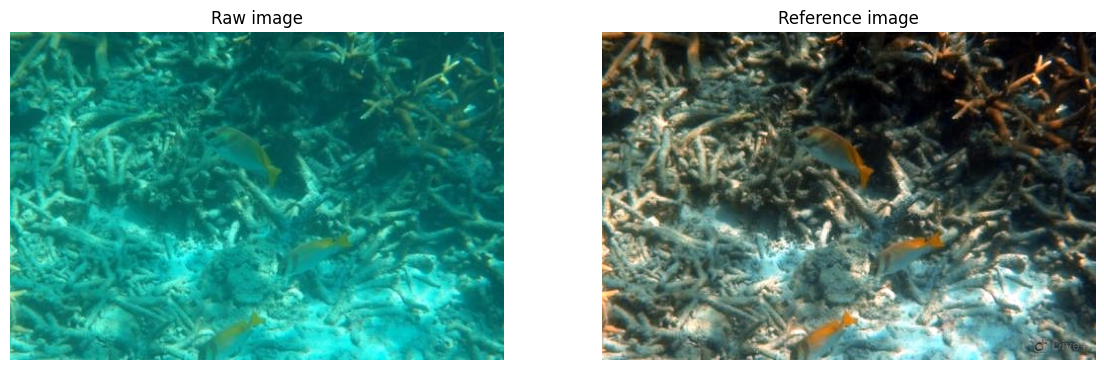

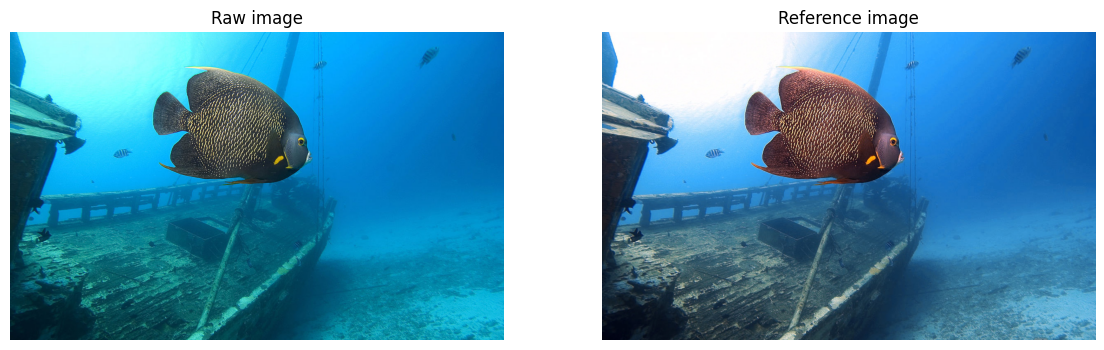

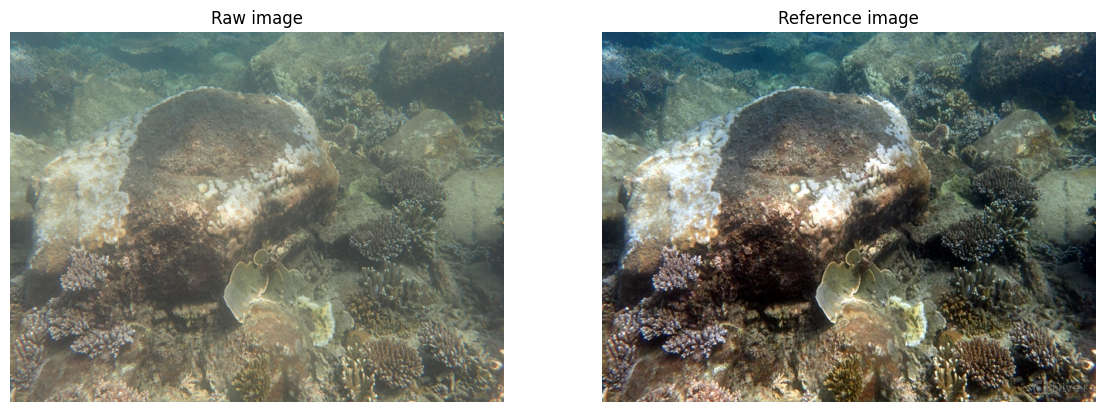

In [9]:
# Display a grid of randomly selected raw images from the dataset
show_image_grid(image_path=images_raw, grid_size=(3, 6), image_size=(16, 8))

# Visualize a comparison between raw images and their corresponding reference images
for i in range(1, 4):
    raw_img, ref_img = sample_images()
    # Display each pair of raw and reference images side by side for visual comparison
    compare_images([raw_img, ref_img], ["Raw image", "Reference image"], (14, 14))
plt.show()  # Ensure all plots are displayed

**Underwater Image Enhancement with Reinforcement Learning**


Existing approaches used to address the problem of Underwater Image Enhancement present some **limitations**:

* Given the complexity of the underwater environment, a single image processing method is not able to adapt to different scenes (such as different turbidities, different lighting conditions, and shots from different angles), causing inconsistency in performance (imprecise or incorrect improvements).

* Models based on Deep Learning methods, which are usually structured with an end-to-end network, apply processing that is effectively a black box, reducing the model's explainability and preventing insights for improvement.

* Training a deep network requires a large number of training data pairs, consisting of a raw image and a reference image, considered the ground truth and obtained through selection made by expert users, since it is not possible to have a true ground truth image. The reference image for such models acts as an upper limit for the quality of the image obtained from the raw image, preventing the generation of better images.

Reinforcement Learning presents itself as an effective method to overcome these limitations. It indeed provides a strategy to organize an optimal sequence of actions that exploit basic image enhancement methods to achieve the goal of effective overall image improvement, as can be seen in the figure below. Each action in the optimal sequence consists of a specific image processing technique so that the entire sequence of actions is transparent.

Furthermore, the possibility of performing both exploration and exploitation could allow for obtaining images of better quality compared to the reference image.

The model solves a Markov Decision Process (MDP) that consists of the interaction at each step $t$ between an **agent** and an **environment**. The MDP is composed of four components:

* a **state** $s_t \in S$ which consists of the set of information that the agent perceives from the environment: in our case, the state is made up of features extracted from the environment's images.
* an **action** $a_t \in A$ which consists of any behavior that the agent can perform in the environment: in our case, it involves image enhancement operations.
* a **reward** $r_t \in R$ which is feedback that the agent receives from the environment after performing an action: in our case, the reward defines how much the action produces a result closer to the ground truth image compared to the starting image.
* a **policy** $\Omega_\theta$ which is the strategy that the agent applies to decide what its next action will be based on the current state it is in.

<div>
<img src="https://drive.google.com/uc?id=1UwwcV3C-_l-Z7VXDclhyf74ewYX-03vt" width="1000"/>
</div>

## **General Framework**


The general framework used is composed of four parts:

1. **Feature Extraction Module**: extracts features from an image. The extracted features will constitute the states.
2. **Deep Q-Network**: takes a state as input and returns a $Q(s,a)$ value for each action.
3. **Action Selection Module**: chooses an action using an ϵ-greedy policy.
4. **Reward Calculation** in terms of image improvement. This part is present only during training.

Below is an illustrative chart of the framework:

<div>
<img src="https://drive.google.com/uc?id=1CakA90pErEueJYFttAVgBEuugUt9hNHG" width="1000"/>
</div>

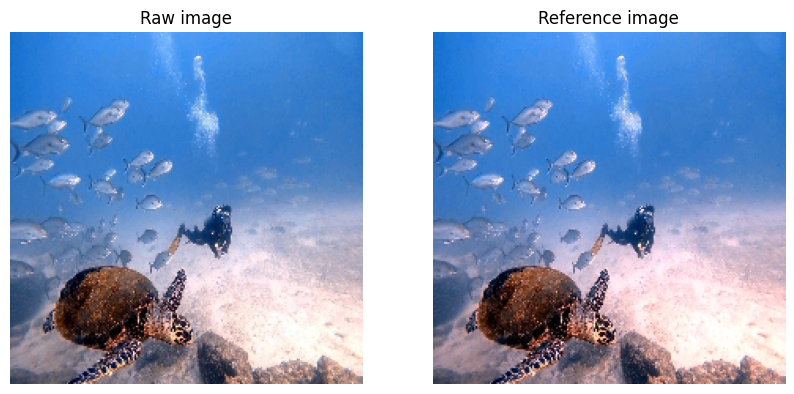

In [10]:
# Load a random image and its corresponding reference image for testing purposes.
# The images are resized to 224x224 pixels.
random_image, random_reference = sample_images(target_size=(224, 224))

# Display the raw and reference images side by side for visual comparison.
# The figure size is set to 10x10 inches.
compare_images(
    [random_image, random_reference], ["Raw image", "Reference image"], (10, 10)
)

### Actions


As actions, **image enhancement** techniques are used. Below are the four categories of techniques employed, each followed by a detailed list of the specific techniques belonging to that category:

**Basic Adjustments**
1. Brightness +5%
2. Brightness -5%
3. Contrast +5%
4. Contrast -5%
5. Color Saturation +5%
6. Color Saturation -5%

**Color Adjustments**
7. Red +5%
8. Red -5%
9. Green +5%
10. Green -5%
11. Blue +5%
12. Blue -5%

**Corrections**
13. Gamma Transformation +
14. Gamma Transformation -
15. HE
16. CLAHE
17. White Balance

**Deblurring**
18. Sharpen
19. Emboss
20. DCP

Less intuitive actions are described in the following subsections.

`apply_action` is a function that allows applying an action on an image and returns the improved image as a result.
  * `action_code` is the code of the action to apply
  * `img` is the image on which to apply the selected action


In [11]:
# Number of defined actions
actions_number = 20

# Image augmentation sequences for sharpening and embossing
seq_sharpen = iaa.Sequential([iaa.Sharpen(alpha=0.05)])
seq_emboss = iaa.Sequential([iaa.Emboss(alpha=0.05)])


def apply_action(action_code, img):
    """
    Apply specified image enhancement action on an image.

    Args:
    action_code (int): Numeric code representing the image enhancement action.
    img (PIL.Image): Image on which to apply the action.

    Returns:
    PIL.Image: Enhanced image.
    """
    # Adjust brightness by +/- 5%
    if action_code in [0, 1]:
        factor = 1.05 if action_code == 0 else 0.95
        converter = ImageEnhance.Brightness(img)
        return converter.enhance(factor)

    # Adjust contrast by +/- 5%
    elif action_code in [2, 3]:
        factor = 1.05 if action_code == 2 else 0.95
        converter = ImageEnhance.Contrast(img)
        return converter.enhance(factor)

    # Adjust color saturation by +/- 5%
    elif action_code in [4, 5]:
        factor = 1.05 if action_code == 4 else 0.95
        converter = ImageEnhance.Color(img)
        return converter.enhance(factor)

    # Adjust specific color channel intensity by +/- 5%
    elif action_code in [6, 7, 8, 9, 10, 11]:
        factor = 1.05 if action_code in [6, 8, 10] else 0.95
        red, green, blue = img.split()  # Split image into RGB channels

        if action_code in [6, 7]:  # Red channel adjustment
            red = red.point(lambda i: i * factor)
        elif action_code in [8, 9]:  # Green channel adjustment
            green = green.point(lambda i: i * factor)
        else:  # Blue channel adjustment
            blue = blue.point(lambda i: i * factor)

        return Image.merge("RGB", (red, green, blue))

    else:
        img_array = np.array(img)  # Convert PIL image to numpy array

        # Gamma correction
        if action_code in [12, 13]:
            gamma = 1.5 if action_code == 12 else 0.5
            return gammaCorrection(img_array, gamma)
        # Histogram equalization, CLAHE, and white balance
        elif action_code in [14, 15, 16]:
            opencv_image = cv.cvtColor(
                img_array, cv.COLOR_RGB2BGR
            )  # Convert to OpenCV image format
            if action_code == 14:
                return heq(opencv_image)  # Histogram equalization
            elif action_code == 15:
                return claheq(opencv_image)  # CLAHE
            else:
                return white_balance(opencv_image)  # White balance

        # Apply sharpening or embossing
        elif action_code in [17, 18]:
            img_array = np.expand_dims(img_array, axis=0)
            if action_code == 17:
                modified_array = seq_sharpen(images=img_array)  # Sharpening
            else:
                modified_array = seq_emboss(images=img_array)  # Embossing
            return Image.fromarray(modified_array[0])

        # DCP dehazing
        elif action_code == 19:
            opencv_image = cv.cvtColor(img_array, cv.COLOR_RGB2BGR)
            return dehaze(
                opencv_image, refine=False
            )  # Dehazing without pipe filtering for faster operation

        else:
            print("Unsupported action", action_code)
            return img

#### White balance

White Balance (WB) is used to eliminate color dominance to return to a completely white light spectrum, where all colors are present in the same quantity.
For implementation, the Grayworld algorithm is used.

**Grayworld assumption**

Assuming a good distribution of colors in the scene, the *Grayworld assumption* is based on the premise that, on average, the real world tends to gray and estimates the color of the light using the average color of all pixels. It is assumed that the information, given by the average of each image channel, is representative of the gray level.

The reason for transforming the input image into the CIELAB color space is to estimate the light source. It consists of two chromatic components, a and b, and a third component that expresses the degree of brightness, unrelated to them. The latter contains no color information.


In [12]:
# White balance adjustment using the Grayworld assumption in CIE LAB color space
# Reference: https://pippin.gimp.org/image-processing/chapter-automaticadjustments.html#


def white_balance(opencv_image):
    """
    Perform white balance on an image using the Grayworld assumption in the CIE LAB color space.

    This function adjusts the color balance of an image so that the average color appears as gray,
    which is assumed to represent the color of the lighting in the scene. The function corrects the image
    by scaling the chroma components (a and b) based on the luminance component (L).

    Parameters:
        opencv_image (numpy.ndarray): The input image in OpenCV format (BGR).

    Returns:
        PIL.Image: The white-balanced image as a PIL Image object.
    """
    # Convert BGR image to LAB color space
    lab_image = cv.cvtColor(opencv_image, cv.COLOR_BGR2LAB)

    # Calculate the average of the a and b components across the image
    avg_a = np.average(lab_image[:, :, 1])
    avg_b = np.average(lab_image[:, :, 2])

    # Adjust the a and b components based on their deviation from the center (128) scaled by luminance
    lab_image = lab_image.astype(
        np.float32
    )  # Convert to float to prevent data type issues during subtraction
    lab_image[:, :, 1] -= (
        (avg_a - 128) * (lab_image[:, :, 0] / 255.0) * 1.1
    )  # Adjust 'a' component
    lab_image[:, :, 2] -= (
        (avg_b - 128) * (lab_image[:, :, 0] / 255.0) * 1.1
    )  # Adjust 'b' component
    lab_image = np.clip(lab_image, 0, 255).astype(
        np.uint8
    )  # Clip values to valid range and convert back to uint8

    # Convert LAB image back to RGB color space
    rgb_image = cv.cvtColor(lab_image, cv.COLOR_LAB2RGB)

    # Convert numpy array to PIL Image
    pil_image = Image.fromarray(rgb_image)

    return pil_image

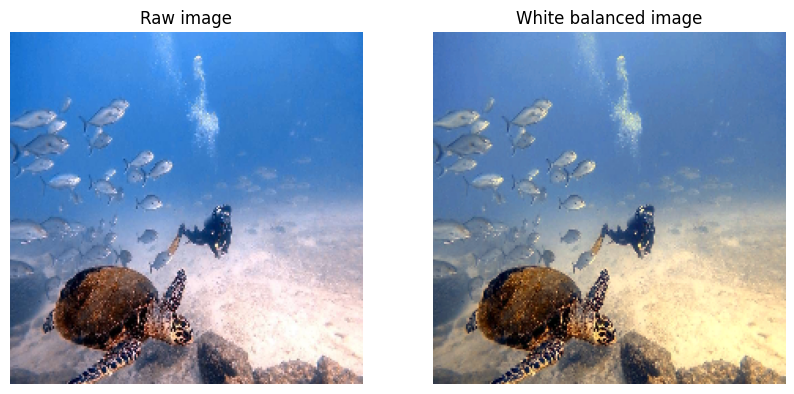

In [13]:
# Apply white balance adjustment to the image using the specified action code
white_balanced_opencv = apply_action(action_code=16, img=random_image)

# Compare the original and white-balanced images and display them side by side
compare_images(
    [random_image, white_balanced_opencv],
    ["Raw image", "White balanced image"],
    (10, 10),
)

#### Dark Channel Prior (DCP)

This technique, which is usually used for haze removal in outdoor scene images, has also been widely used for the recovery of underwater images.

For more information on DCP, refer to paper [3] in the *Literature References* section.

* It is implemented in the **dehaze()** function.

* The guided_filter() function is additional, and is used to refine the image obtained from dehaze(), which can sometimes be a bit grainy.


In [14]:
"""Implementation for Guided Image Filtering
   -  The main reason for using guided image filtering is to refine the transmission map obtained from dehazing methods, which can be too coarse. He Kai Ming introduced the Soft Matting method to address this, but it is computationally intensive and not suitable for real-time applications. Guided filtering, introduced in 2011, offers a faster alternative that still achieves fine results through local linear models.
   -  The implementation of guided_filter() used here is adapted from https://github.com/joyeecheung/dark-channel-prior-dehazing/blob/master/src/guidedfilter.py
   -  For more information about the algorithm, refer to the documentation at https://github.com/joyeecheung/dark-channel-prior-dehazing/tree/master/doc
"""

# Indices for RGB channels for convenience
R, G, B = 0, 1, 2


def boxfilter(I, r):
    """Performs a box filter operation on a single channel image.

    This function computes the cumulative sum over the image to perform a fast box filtering operation, which is used as a building block in guided filtering to compute local means and variances efficiently.

    Parameters
    ----------
    I : numpy.ndarray
        A single channel/gray image data normalized to [0.0, 1.0].
    r : int
        Window radius for the box filter.

    Returns
    -------
    numpy.ndarray
        The filtered image data.
    """
    M, N = I.shape
    dest = np.zeros((M, N))
    # Cumulative sum over Y axis
    sumY = np.cumsum(I, axis=0)
    # Difference over Y axis
    dest[: r + 1] = sumY[r : 2 * r + 1]
    dest[r + 1 : M - r] = sumY[2 * r + 1 :] - sumY[: M - 2 * r - 1]
    dest[-r:] = np.tile(sumY[-1], (r, 1)) - sumY[M - 2 * r - 1 : M - r - 1]
    # Cumulative sum over X axis
    sumX = np.cumsum(dest, axis=1)
    # Difference over X axis
    dest[:, : r + 1] = sumX[:, r : 2 * r + 1]
    dest[:, r + 1 : N - r] = sumX[:, 2 * r + 1 :] - sumX[:, : N - 2 * r - 1]
    dest[:, -r:] = (
        np.tile(sumX[:, -1][:, None], (1, r)) - sumX[:, N - 2 * r - 1 : N - r - 1]
    )
    return dest


def guided_filter(I, p, r=40, eps=1e-3):
    """Refines an input filter under the guidance of an RGB image.

    This function implements the guided filter which is a local linear model based edge-preserving filter. It is used to enhance the quality of the transmission map obtained from dehazing methods.

    Parameters
    ----------
    I : numpy.ndarray
        An MxNx3 RGB image for guidance.
    p : numpy.ndarray
        The MxN filter to be refined.
    r : int, optional
        The radius of the guidance window.
    eps : float, optional
        Regularization parameter to avoid division by zero.

    Returns
    -------
    numpy.ndarray
        The refined guided filter.
    """
    M, N = p.shape
    base = boxfilter(np.ones((M, N)), r)
    # Mean of each channel of I
    means = [boxfilter(I[:, :, i], r) / base for i in range(3)]
    # Mean of p
    mean_p = boxfilter(p, r) / base
    # Cross mean of I and p
    means_IP = [boxfilter(I[:, :, i] * p, r) / base for i in range(3)]
    # Covariance of (I, p) in each local patch
    covIP = [means_IP[i] - means[i] * mean_p for i in range(3)]
    # Variance of I in each local patch
    var = defaultdict(dict)
    for i, j in combinations_with_replacement(range(3), 2):
        var[i][j] = boxfilter(I[:, :, i] * I[:, :, j], r) / base - means[i] * means[j]
    a = np.zeros((M, N, 3))
    for y, x in np.ndindex(M, N):
        Sigma = np.array(
            [
                [var[R][R][y, x], var[R][G][y, x], var[R][B][y, x]],
                [var[R][G][y, x], var[G][G][y, x], var[G][B][y, x]],
                [var[R][B][y, x], var[G][B][y, x], var[B][B][y, x]],
            ]
        )
        cov = np.array([c[y, x] for c in covIP])
        a[y, x] = np.dot(
            cov, np.linalg.inv(Sigma + eps * np.eye(3))
        )  # Solve linear system
    # Compute the output using the coefficients
    b = mean_p - a[:, :, R] * means[R] - a[:, :, G] * means[G] - a[:, :, B] * means[B]
    q = (
        boxfilter(a[:, :, R], r) * I[:, :, R]
        + boxfilter(a[:, :, G], r) * I[:, :, G]
        + boxfilter(a[:, :, B], r) * I[:, :, B]
        + boxfilter(b, r)
    ) / base
    return q

**dehaze()**

In computer vision, the formation of a blurred image is usually described by the following model:

$$\mathbf{I}(\mathbf{x}) = \mathbf{J}(\mathbf{x})t(\mathbf{x}) + \mathbf{A}(1 - t(\mathbf{x}))$$

where $I(x)$ is the observed blurred image, $J(x)$ is the scene brightness ("the clean image") to be recovered, $A$ is the global atmospheric light, and $t$ is the medium transmission.

In [3] He proposed a method to reduce haze from outdoor images. Given an image $J$, its dark channel is calculated as:

$$
J^{dark}(\mathbf{x}) = min_{c \in \{r,g,b\}}( min_{\mathbf{y} \in \Omega(\mathbf{x})}(J^c(\mathbf{y})))
$$

$J$ is an outdoor image without haze, the intensity of $J^{dark}$ in the image region where the sky is not included is close to 0.

The idea is formed from the assumption that there are many dark areas in images where there is no sky whose pixels will have at least one color channel with a very low value.

Thus, the transmission can be estimated as:

$$
\tilde{t}(\mathbf{x}) = 1 - \omega min_{c}( min_{\mathbf{y} \in \Omega(\mathbf{x})}(\frac{I^c(\mathbf{y})}{A^c}))
$$

where $\omega \in (0, 1]$ is a constant to maintain a certain amount of haze to keep the result as natural as possible. Here $min_{c}( min_{\mathbf{y} \in \Omega(\mathbf{x})}(\frac{I^c(\mathbf{y})}{A^c}))$ is the dark channel of the haze-normalized image $\frac{I^c(\mathbf{y})}{A^c}$.

To obtain $A$ from the input image, the p% brightest pixels in the dark channel must first be selected, then, for each color channel, the one with the highest intensity in the input image ${I}$ is chosen as its atmospheric light.

Once $\tilde{t}(\mathbf{x})$, ${A}$, and ${I}$ are obtained, the haze-free image can be calculated with the following formula:

$$
\mathbf{J}(\mathbf{x}) = \frac{\mathbf{I}(\mathbf{x}) - \mathbf{A}}{max(\tilde{t}(\mathbf{x}),t_0)} + \mathbf{A}
$$

where $t_0$ is a lower limit for $t$ to preserve a certain amount of haze in areas where it is denser.


In [17]:
# Single-Image Haze Removal Using Dark Channel Prior

%matplotlib inline

class Node(object):
    """
    A class to store the original pixel position and its value.
    
    Attributes:
        x (int): The x-coordinate of the pixel.
        y (int): The y-coordinate of the pixel.
        value (int): The value of the pixel.
    """
    def __init__(self, x, y, value):
        self.x = x
        self.y = y
        self.value = value

    def printInfo(self):
        """Prints the information of the node."""
        print(f'{self.x}:{self.y}:{self.value}')
        
def getMinChannel(img):
    """
    Extracts the minimum value across the three BGR channels of an image.
    
    Args:
        img (numpy.ndarray): The input image as a 3D numpy array.
        
    Returns:
        numpy.ndarray: A 2D array representing the minimum channel values of the input image.
    """
    if len(img.shape) == 3 and img.shape[2] == 3:
        return np.min(img, axis=2)
    else:
        print("Bad image shape, input must be a color image")
        return None
   
def getDarkChannel(img, blockSize=3):
    """
    Computes the dark channel prior for an image.
    
    Args:
        img (numpy.ndarray): The input image as a 2D numpy array.
        blockSize (int): The size of the local patch, default is 3.
        
    Returns:
        numpy.ndarray: A 2D array representing the dark channel of the input image.
    """
    if len(img.shape) != 2:
        print("Bad image shape, input image must be two dimensions")
        return None

    if blockSize % 2 == 0 or blockSize < 3:
        print('BlockSize is not odd or too small')
        return None

    A = (blockSize - 1) // 2  # Padding size
    H, W = img.shape[0] + blockSize - 1, img.shape[1] + blockSize - 1
    imgMiddle = 255 * np.ones((H, W))
    imgMiddle[A:H-A, A:W-A] = img
    imgDark = np.zeros_like(img, np.uint8)
    
    for i in range(A, H-A):
        for j in range(A, W-A):
            imgDark[i-A, j-A] = np.min(imgMiddle[i-A:i+A+1, j-A:j+A+1])
    
    return imgDark

def getAtomsphericLight(darkChannel, img, meanMode=False, percent=0.001):
    """
    Estimates the atmospheric light in the image.
    
    Args:
        darkChannel (numpy.ndarray): The dark channel of the image.
        img (numpy.ndarray): The original image.
        meanMode (bool): Flag to use mean mode for atmospheric light calculation.
        percent (float): The percentage of pixels to consider for the estimation.
        
    Returns:
        int: The estimated atmospheric light intensity.
    """
    size = darkChannel.size
    height, width = darkChannel.shape
    nodes = [Node(i, j, darkChannel[i, j]) for i in range(height) for j in range(width)]
    nodes.sort(key=lambda node: node.value, reverse=True)

    if int(percent * size) == 0:
        return max(img[nodes[0].x, nodes[0].y])

    if meanMode:
        total = sum(img[node.x, node.y].sum() for node in nodes[:int(percent * size)])
        return int(total / (int(percent * size) * 3))

    return max(img[node.x, node.y].max() for node in nodes[:int(percent * size)])

def dehaze(img, omega=0.95, t0=0.1, blockSize=15, meanMode=False, percent=0.001, refine=True):
    """
    Performs image dehazing using the dark channel prior method.
    
    Args:
        img (numpy.ndarray): The input hazy image.
        omega (float): The amount of haze to keep in the image.
        t0 (float): The lower bound for transmission.
        blockSize (int): The size of the block for calculating the dark channel.
        meanMode (bool): Flag to use mean mode for atmospheric light calculation.
        percent (float): The percentage of pixels to consider for atmospheric light estimation.
        refine (bool): Flag to apply a guided filter to refine the results.
        
    Returns:
        PIL.Image: The dehazed image.
    """
    imgGray = getMinChannel(img)
    imgDark = getDarkChannel(imgGray, blockSize=blockSize)
    atomsphericLight = getAtomsphericLight(imgDark, img, meanMode=meanMode, percent=percent)

    imgDark = np.float64(imgDark)
    transmission = 1 - omega * imgDark / atomsphericLight
    transmission = np.clip(transmission, t0, 1)  # Ensure transmission is within the range [t0, 1]

    if refine:
        normI = (img - img.min()) / (img.max() - img.min())  # Normalize I
        transmission = guided_filter(normI, transmission, r=40, eps=1e-3)

    sceneRadiance = np.clip((img - atomsphericLight) / transmission[:, :, np.newaxis] + atomsphericLight, 0, 255)
    sceneRadiance = np.uint8(sceneRadiance)
    resultPil = cv.cvtColor(sceneRadiance, cv.COLOR_BGR2RGB)
    return Image.fromarray(resultPil)


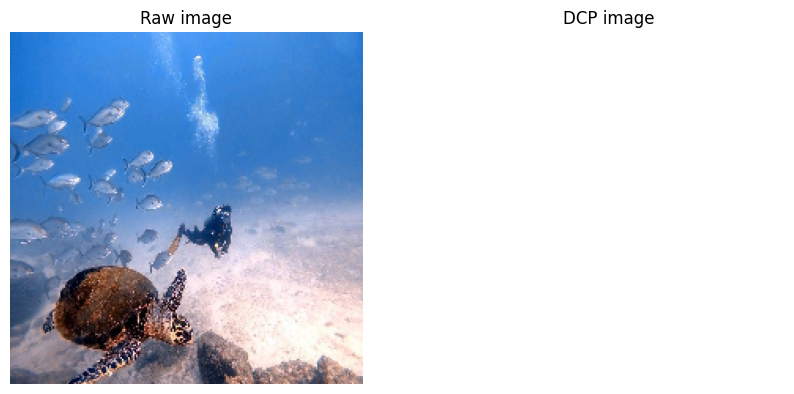

In [19]:
# Apply a specific action to the image using the action code 19.
# Note: The pipe filtering implementation is set to false.
dcp_opencv = apply_action(
    action_code=19, img=random_image
)  # Function invocation: apply_action

# Compare the original image with the processed image using DCP and display them side by side.
compare_images(
    [random_image, dcp_opencv], ["Raw image", "DCP image"], (10, 10)
)  # Function invocation: compare_images

#### Gamma Correction
# 


Gamma transformation corrects underwater images that are either too bright (overexposed) or too dark (underexposed).

The correction is used to encode or decode the luminance of an image based on the gamma parameter used.

A gamma value greater than 1 is called **encoding gamma** and the correction process is known as **gamma compression**, while a gamma value less than 1 is called **decoding gamma** and the process is called **gamma expansion**.

The method to solve gamma correction is fast: it involves building a table that maps the pixel values of the input image to the correct gamma output values. From the table, the output value for a given pixel is quickly determined.

The table is then created by iterating over all pixels in the range [0,255]. The pixel value is then scaled to the range [0,1.0] and multiplied by the inverse of gamma - this value is then saved in the table.
The **cv.LUT** function of openCV is then applied, which takes the image and the table as parameters and finds the correct mappings for each pixel value.


In [ ]:
def gammaCorrection(opencv_image, gamma):
    """
    Apply gamma correction to an OpenCV image using a specified gamma value.

    Gamma correction is used to encode or decode the luminance of the image.
    A gamma value > 1 will darken the image, while a gamma < 1 will brighten it.

    Args:
    opencv_image (numpy.ndarray): The input image in OpenCV format.
    gamma (float): The gamma correction value. Values > 1 will darken the image, values < 1 will brighten it.

    Returns:
    PIL.Image: The gamma corrected image.
    """
    # Calculate the inverse of gamma to build the lookup table
    invGamma = 1.0 / gamma
    # Create a lookup table mapping the pixel values [0, 255] to their adjusted gamma values
    table = np.array(
        [((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]
    ).astype("uint8")
    # Apply gamma correction using the lookup table
    correctedArray = cv.LUT(opencv_image, table)
    # Convert the corrected array to a PIL image and return
    return Image.fromarray(correctedArray)

In [ ]:
# Apply a gamma reduction action to the random image
image_1 = apply_action(
    action_code=12, img=random_image
)  # action_code=12 might correspond to gamma reduction
# Apply a gamma increase action to the random image
image_2 = apply_action(
    action_code=13, img=random_image
)  # action_code=13 might correspond to gamma increase

# Compare the images with different gamma corrections and the original image
compare_images(
    [image_1, random_image, image_2], ["Gamma -", "Raw image", "Gamma +"], (10, 10)
)  # Displays a comparison of images with reduced, original, and increased gamma

#### Histogram Equalization and Contrast Limited Adaptive Histogram Equalization (HE e CLAHE) 




The **histogram** is a graphical representation of the tonal distribution of an image: the x-axis shows the tone variation, while the y-axis shows the number of pixels corresponding to that tone.

Typically, the intensity values of images are very close to each other. **Histogram Equalization** is an image processing method that allows for contrast calibration using the image's histogram by distributing the most frequent intensity values more evenly.

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/7/71/Histogrammspreizung.png" width="500"/>
</div>

Standard HE amplifies the contrast in the vicinity of constant areas, which can lead to the amplification of noise in these areas. **Contrast Limited Adaptive Histogram Equalization** introduces a limit to contrast amplification to reduce this problem.

The OpenCV library provides a function to apply histogram equalization, **equalizeHist**. HE works well on a grayscale image, but not on an RGB image. A solution can be to convert the image to the YUV color space and apply equalization on the Y channel, and then convert the image back to RGB.


In [ ]:
def heq(opencv_image):
    """
    Apply histogram equalization to an image in the YUV color space.

    This function converts an input image from the BGR to YUV color space, applies histogram equalization
    to the Y channel (luminance), and then converts it back to RGB for display purposes.

    Args:
    opencv_image (numpy.ndarray): The input image in BGR color format.

    Returns:
    PIL.Image: The output image with histogram equalization applied, in RGB format.
    """
    # Convert the input BGR image to the YUV color space
    img_to_yuv = cv.cvtColor(opencv_image, cv.COLOR_BGR2YUV)
    # Apply histogram equalization to the Y channel
    img_to_yuv[:, :, 0] = cv.equalizeHist(img_to_yuv[:, :, 0])
    # Convert the YUV image back to BGR color space after equalization
    hist_equalization_result = cv.cvtColor(img_to_yuv, cv.COLOR_YUV2BGR)
    # Convert the BGR image to RGB color space for final output
    resultPil = cv.cvtColor(hist_equalization_result, cv.COLOR_BGR2RGB)
    # Convert the result into a PIL Image and return
    pil_image = Image.fromarray(resultPil)
    return pil_image

The same aforementioned problem occurs in CLAHE, where the image will be converted to the LAB color space, and equalization is applied on the L channel.


In [ ]:
def claheq(opencv_image):
    """
    Apply Contrast Limited Adaptive Histogram Equalization (CLAHE) to an image.

    This function converts an input image from the BGR to LAB color space, applies CLAHE
    to the L channel (luminance), and then converts the image back to RGB for display purposes.

    Args:
    opencv_image (numpy.ndarray): The input image in BGR color format.

    Returns:
    PIL.Image: The output image with CLAHE applied, in RGB format.
    """
    # Convert the input BGR image to the LAB color space
    img = cv.cvtColor(opencv_image, cv.COLOR_BGR2LAB)
    # Configure CLAHE with a clip limit and tile grid size
    # clipLimit: Threshold for contrast limiting to reduce noise
    # tileGridSize: Size of the grid for local histogram equalization
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    # Apply CLAHE to the 'L' channel (index 0) of the LAB image
    img[:, :, 0] = clahe.apply(img[:, :, 0])
    # Convert the LAB image back to BGR color space after applying CLAHE
    img = cv.cvtColor(img, cv.COLOR_LAB2BGR)
    # Convert the BGR image to RGB color space for final output
    resultPil = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    # Convert the result into a PIL Image and return
    return Image.fromarray(resultPil)

In [ ]:
# Apply histogram equalization to the image using the specified action code
image_1 = apply_action(
    action_code=14, img=random_image
)  # HE (Histogram Equalization) visualization
# Apply CLAHE to the image using the specified action code
image_2 = apply_action(
    action_code=15, img=random_image
)  # CLAHE (Contrast Limited Adaptive Histogram Equalization) visualization
# Compare the original, HE, and CLAHE images in a 10x10 figure
compare_images(
    [image_1, random_image, image_2], ["HE image", "Raw image", "CLAHE image"], (10, 10)
)

#### Sharpen


The sharpen filter makes the transition from one region of the image to another more obvious


In [ ]:
# Apply a sharpening filter to the image using the specified action code
sharpenedImage = apply_action(
    action_code=17, img=random_image
)  # Action code 17 corresponds to the sharpening filter

# Display a comparison between the original and the sharpened images
compare_images(
    [random_image, sharpenedImage], ["Raw image", "Sharpened image"], (10, 10)
)

#### Emboss

Emboss applies a filter to the image to create a 3D relief cast of it.


In [ ]:
# Apply the emboss filter to the image using the specified action code
embossedImage = apply_action(
    action_code=18, img=random_image
)  # action_code 18 for embossing

# Display a comparison between the original and the embossed images in a 10x10 figure
compare_images([random_image, embossedImage], ["Raw image", "Embossed image"], (10, 10))

### States


Individual states are composed of the set of features extracted from the input image. At the moment $t_i$, an action is applied to the starting image, resulting in an "enhanced" image from which features will be extracted to form the state at the moment $t_{i+1}$.


### Feature extraction



Two different types of features are extracted from the image, which will constitute the initial state that will then be perceived by the agent:
* **Colour feature**: global features, describe the properties of the image surface
* **Perceptual feature**: context-dependent features, inspired by human vision.


#### Colour feature


Regarding colour features, the image is converted from RGB colour space to Lab (CIELAB) space.

The RGB space, encoded on three bytes, can represent 40% of the colors that the human eye can perceive. 
The CIE offers colour spaces to expand the range of possibilities to what humans can actually perceive. Among these is the CIELAB colour space, which aims to best represent colour perception for the human eye and also estimates the light source.

The CIE L*a*b* model is a three-dimensional space where the *L* dimension specifies the degree of **brightness**, the *a* dimension includes the **opposite colours red and green**, and the *b* dimension includes the **opposite colours yellow and blue**.

* **L axis**: values range from 0=black to 100=white
* **a axis**: negative values=green, or positive values=red
* **b axis**: negative values=blue, or positive values=yellow

<div>
<img src="https://drive.google.com/uc?id=15vjH7JX4wc19BDTYZ-1KgRg1P0iIi_uL" width="400"/>
</div>

CIELAB can be suitable for training learning models. According to recent studies, it has proven more effective than the RGB colour space.

The **histogram** represents the distribution of pixel intensity in the image. Each axis of the CIELab space is divided into 20 intervals, and the number of pixels in each interval is calculated. In our case, a binning of 20 intervals per channel was used, resulting in a 20x20x20 histogram that contains the values of the colour features.

The `calcHist` function from CV2 was used to calculate the histogram:


In [ ]:
# Convert the random image to a numpy array
image_array = np.array(random_image)

# Convert the RGB image to CIELAB color space using OpenCV
# Note: In OpenCV, LAB values are scaled to the range [0, 255]
lab = cv.cvtColor(image_array, cv.COLOR_RGB2LAB)

# Calculate the range of L, a, and b channels in the LAB color space
l_range = [np.min(lab[:, :, 0]), np.max(lab[:, :, 0])]
a_range = [np.min(lab[:, :, 1]), np.max(lab[:, :, 1])]
b_range = [np.min(lab[:, :, 2]), np.max(lab[:, :, 2])]
print("Ranges for L, a, b channels: ", l_range, a_range, b_range)

# Set the number of bins for the histogram
bin_count = 256

# Calculate and plot the histogram for each channel in the LAB color space
for i, col in enumerate(["L", "a", "b"]):
    # Calculate histogram for each channel
    hist = cv.calcHist([lab], [i], None, [bin_count], [0, 256])
    print("Histogram shape for channel", col, ":", hist.shape)
    plt.plot(hist, label=col)
    plt.xlim([0, bin_count])

plt.legend()
plt.title("CIELAB Color Space Histogram")
plt.show()

The 3D histogram is calculated, obtaining the color feature vector, composed of 8000 values.


In [ ]:
def get_color_feature(img_array, flatten=False):
    """
    Converts an image from RGB to LAB color space and computes a 3D histogram.

    Args:
    img_array (numpy.ndarray): Input image array in RGB format.
    flatten (bool): If True, the histogram is flattened before being returned.

    Returns:
    numpy.ndarray: The 3D histogram of the LAB image, either flattened or as a 3D array.
    """
    # Convert the RGB image to LAB color space; OpenCV scales LAB values to [0, 255].
    lab = cv.cvtColor(img_array, cv.COLOR_RGB2LAB)

    # Define the channels and bins for the histogram calculation.
    channels = [0, 1, 2]  # L, a, and b channels
    bins = [20, 20, 20]  # 20 bins for each channel
    ranges = [0, 256, 0, 256, 0, 256]  # Range for each channel

    # Calculate the 3D histogram for the LAB image.
    histogram = cv.calcHist([lab], channels, None, bins, ranges)

    # Flatten the histogram if requested.
    if flatten:
        return histogram.flatten()
    else:
        return histogram

In [ ]:
# Verify that the `get_color_feature` function extracts 8000 features from the image
image_array = np.array(random_image)  # Convert the random image to a NumPy array
print(
    "Color feature count:", get_color_feature(image_array).size
)  # Output the size of the color feature array

#### Perceptual feature


Regarding the extraction of perceptual features, a pretrained **VGG-19 convolutional network** is used.

In the following subsections, the model is described, and the VGG-19 is built and compiled, which will be used throughout the rest of the notebook and will be tested on some sample images.


##### Modello VGG-19



VGGNet-19 takes as input images of size 224x224x3 and is composed of the following layers:

*   16 Convolutional layers
*   5 Max Pooling layers
*   3 Fully Connected layers

VGG also introduces the concept of a block, which is a sequence of convolutional layers with 3x3 kernels followed by a Max Pooling layer with a stride of 2.

The main advantage of using VGG-19 is its high number of layers, which allows it to learn more complex representations of the input data. Compared to VGG-16, for example, VGG-19 is more accurate, but it requires more memory and computational resources.

The architecture of VGGNet-19 is shown in the figure:

<div>
<img src="https://drive.google.com/uc?id=1AUik3SqUJcYaWnKTrM37ZXyKctd8To6C" width="500"/>
</div>

**Why use a pretrained network?**

Lacking a labeled dataset, a model pretrained on the ImageNet dataset was chosen to extract features. Models trained on ImageNet have learned to extract features from a wide variety of images, and should perform well even in the application domain of underwater images.

Keras allows you to instantiate the [**VGG**](https://keras.io/api/applications/vgg/) with the weights of the network pretrained on ImageNet. The `include_top` parameter indicates whether to keep the last dense layers when loading the model or not.


In [ ]:
# Load the pretrained VGG19 model from ImageNet dataset
# This model is commonly used for image classification tasks.
vgg19 = VGG19(
    include_top=True,  # Includes the fully-connected layer at the top of the network
    weights="imagenet",  # Use weights pre-trained on ImageNet
    input_tensor=None,  # No custom input tensor
    input_shape=None,  # Default input shape for VGG19 is 224x224x3
    pooling=None,  # No pooling applied at the top of the network
    classes=1000,  # Number of classes for ImageNet dataset
    classifier_activation="softmax",  # Use softmax activation for the output layer
)

##### Model Visualization


In [ ]:
vgg19.summary()

In [ ]:
# plot_model(vgg19, show_shapes=True)

##### Model Compilation
# 


As a final step, the model is compiled choosing:

*   Optimization algorithm: **ADAM**
*   Loss function: **Categorical Cross-Entropy**
*   Model performance evaluation metrics: **Accuracy**


In [ ]:
opt = Adam(learning_rate=0.001)

vgg19.compile(optimizer=opt, loss=categorical_crossentropy, metrics=["accuracy"])

##### Feature Extraction


Taking a random image from the dataset, features are extracted by taking the output from one of the fully connected layers, as indicated in the paper. This results in 4096 perceptual features, corresponding to the number of output neurons of the extraction layer.


In [ ]:
# Create a new model that outputs features from the 'fc1' dense layer of the VGG19 model
hidden_features_vgg = Model(inputs=vgg19.input, outputs=vgg19.get_layer("fc1").output)


def get_perceptual_features(img_array, model=hidden_features_vgg, flatten=False):
    """
    Extract perceptual features from an image using a specified model.

    Args:
    img_array (np.array): The input image array.
    model (tf.keras.Model): The model to use for feature extraction, default is hidden_features_vgg.
    flatten (bool): If True, flattens the output to a 1D array, default is False.

    Returns:
    np.array: The extracted features, either as a matrix or a flattened array.
    """
    # Expand the dimensions of the image array to match the input requirements of the VGG model
    image_values = np.expand_dims(img_array, axis=0)
    # Preprocess the image values to match the expected input format of the model
    image_values = preprocess_input(image_values)

    # Predict the features using the model
    features = model.predict(image_values, verbose=0)
    # Flatten the features if requested
    if flatten:
        return features.flatten()
    else:
        return features


# Extract perceptual features from a random image
features = get_perceptual_features(random_image)
# Output the number of extracted perceptual features
print("number of perceptual feature: ", features.size)

##### Example of feature extraction and classification


In [ ]:
# Iterate through each layer in the VGG19 model to summarize the shapes of convolutional filters
for layer in vgg19.layers:
    # Check if the current layer is a convolutional layer by examining its name
    if "conv" not in layer.name:
        continue
    # Retrieve the weights (filters) and biases of the convolutional layer
    filters, biases = layer.get_weights()
    # Print the name of the layer and the shape of its filters
    print(layer.name, filters.shape)

 Displaying the size of the feature maps for each convolutional layer.


In [ ]:
# Iterate through each layer in the VGG19 model and print the output shape of convolutional layers
for i, layer in enumerate(vgg19.layers):
    # Check if the layer is a convolutional layer by looking for "conv" in its name
    if "conv" not in layer.name:
        continue
    # Print the index, layer name, and output shape of the convolutional layer
    print(
        f"Layer Index: {i}, Layer Name: {layer.name}, Output Shape: {layer.output.shape}"
    )

A prediction is made and the 5 most probable class memberships are obtained.


In [ ]:
# Display the randomly selected image
display_image(random_image)

# Decode the predictions by converting the probabilities to class labels, typically returning the top 5 guessed classes
label = decode_predictions(
    get_perceptual_features(random_image, model=vgg19)
)  # Get perceptual features from the VGG19 model

# Extract the most likely result (highest probability) from the predictions
label_most = label[0][0]

# Output the most likely class and its probability
print(
    "The most likely class obtained is: %s (%.2f%%)"
    % (label_most[1], label_most[2] * 100)
)

# Prepare data for a bar plot showing the probabilities of the top classes
classes = []
probabilities = []
for entry in label[0]:
    classes.append(entry[1])
    probabilities.append(entry[2] * 100)

# Create a horizontal bar plot to visualize the class probabilities
fig, ax = plt.subplots()
width = 0.8  # Set the width of the bars
rects1 = ax.barh(classes, probabilities, width, color="r")

# Set labels and title for the plot
ax.set_ylabel("Classes")
ax.set_xlabel("Probabilities (%)")
ax.set_title("Top Class Probabilities")

# Display the plot
plt.show()

#### Feature extraction function


When the `extract_features` function receives an image as input, it returns 12096 features (4096 perceptual features and 8000 color features).

The input image must be converted into a 3D tensor of pixels, which will then be expanded from 3 dimensions to 4. The pixel values must then be appropriately scaled for the VGG model.


In [ ]:
def get_features(img):
    """
    Extracts both color and perceptual features from an image.

    This function converts an image to a numpy array and extracts both color and perceptual features.
    The color features are extracted as a flattened array of 20x20x20 features, and the perceptual features
    are extracted as a flattened array of 4096 features. These features are then concatenated into a single
    feature array.

    Args:
    img (PIL.Image): The image from which features are to be extracted.

    Returns:
    tuple: A tuple containing the concatenated features array, color features array, and perceptual features array.
    """
    # Convert the image to a numpy array of RGB pixel values
    img_array = np.array(img)

    # Extract color features as a flattened array (20x20x20 features)
    color_features = get_color_feature(img_array, flatten=True)

    # Extract perceptual features as a flattened array (4096 features)
    perceptual_features = get_perceptual_features(img_array, flatten=True)

    # Concatenate color and perceptual features into a single array
    features = np.concatenate((color_features, perceptual_features))

    return features, color_features, perceptual_features

In [ ]:
# Testing feature extraction from a randomly selected image
features, color_features, perceptual_features = get_features(
    random_image
)  # Extract features using the get_features function
features_number = len(features)  # Calculate the total number of features extracted

print("number of features: ", features_number)  # Output the total number of features

### Definition of the reward


The reward is expressed as a function of the improvement of the raw image. This improvement is characterized by two distinct losses: a pixelwise loss and a perceptual loss.

The **pixelwise loss** (Mean Absolute Error) measures the pixel-by-pixel distance between the colors of the ground truth image and the improved image following an action. Minimizing this loss reduces the difference between the color of the ground truth image and that obtained by applying actions on the raw image.

> $L_c=\frac{1}{WH} \sum_{w,h} \lvert Y_{w,h} - G(X(t))_{w,h} \rvert$

* W and H are the width and height of the input image
* X is the input image
* Y is the ground truth image
* G(X) is the image improved following an action

The **pixelwise reward** is defined as the difference in pixelwise losses between the improved image and the raw image.

> $R_c=-[L_c(t)-L_c(t-1)]$

The **perceptual loss** (Mean Squared Error) favors visually pleasing images by measuring the distance between feature vectors (in our case, the vectors of features extracted from the first fully-connected layer of the VGG-19). Minimizing this loss reduces the difference between the high-level features extracted from the ground truth image compared to those extracted from the image obtained by applying actions on the raw image.

> $L_p(t)= \frac{1}{F} \sum_{w,h}(\Phi_{VGG}(Y)_{w,h} -\Phi_{VGG}(G(X(t)))_{w,h})^2$

* $F$: number of perceptual features extracted from the image through the VGG-19
* $\Phi_{VGG}(Y)$: the features extracted from the ground truth image
* $\Phi_{VGG}(G(X(t)))$: the features extracted from the improved image following an action

The **perception reward** is defined as the difference in perceptual losses between the improved image and the raw image.

> $R_p(t)=-[L_p(t)-L_p(t-1)]$

The **reward** is finally defined as:

> $R=\alpha R_c + \beta R_p$

$\alpha$ and $\beta$ are **balancing coefficients** (hyperparameters) that are used to stabilize training and are selected empirically. The recommended values in the literature are $1$ and $0.05$ respectively.


#### Calculation of the pixelwise loss


The function `get_pixelwise_reward` calculates the pixelwise reward according to the aforementioned formula.

* `pre_img_color_features` are the color features of the image before the action is applied
* `post_img_color_features` are the color features of the image obtained after the action is applied
* `ref_img_color_features` are the color features of the reference image

The calculation of the **mean absolute error** is delegated to the [MeanAbsoluteError](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanAbsoluteError) function from Keras.


In [ ]:
# Initialize the Mean Absolute Error loss function
mae_loss = MeanAbsoluteError()


def get_pixelwise_reward(
    pre_img_color_features, post_img_color_features, ref_img_color_features
):
    """
    Calculate the pixelwise reward based on the mean absolute error (MAE) between the reference image features
    and the pre-action and post-action image features.

    Args:
    pre_img_color_features (np.array): Color features of the image before the action is applied.
    post_img_color_features (np.array): Color features of the image after the action is applied.
    ref_img_color_features (np.array): Color features of the reference image.

    Returns:
    float: The pixelwise reward, calculated as the difference in MAE between the pre-action and post-action images
           relative to the reference image.
    """
    # Calculate MAE between the reference image and the pre-action image
    pre_ref_mae = mae_loss(ref_img_color_features, pre_img_color_features).numpy()
    # Calculate MAE between the reference image and the post-action image
    post_ref_mae = mae_loss(ref_img_color_features, post_img_color_features).numpy()
    # The reward is the improvement in MAE from pre-action to post-action
    return pre_ref_mae - post_ref_mae

#### Calculation of the perceptual loss


The function `get_perceptual_reward` calculates the perceptual reward according to the aforementioned formula.

* `pre_img_perc_features` are the perceptual features of the image before the action is applied
* `post_img_perc_features` are the perceptual features of the image obtained after the action is applied
* `ref_img_perc_features` are the perceptual features of the reference image

The calculation of the **mean squared error** is delegated to the [MeanSquaredError](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanAbsoluteError) function from Keras.


In [ ]:
# Initialize the Mean Squared Error loss function for perceptual comparison
mse_loss = MeanSquaredError()


def get_perceptual_reward(
    pre_img_perc_features, post_img_perc_features, ref_img_perc_features
):
    """
    Calculate the perceptual reward based on the mean squared error (MSE) between the reference image features
    and the pre-action and post-action image features.

    Args:
    pre_img_perc_features (np.array): Perceptual features of the image before the action is applied.
    post_img_perc_features (np.array): Perceptual features of the image after the action is applied.
    ref_img_perc_features (np.array): Perceptual features of the reference image.

    Returns:
    float: The perceptual reward, calculated as the difference in MSE between the pre-action and post-action images
           relative to the reference image.
    """
    # Calculate MSE between the reference image and the pre-action image
    pre_ref_mse = mse_loss(ref_img_perc_features, pre_img_perc_features).numpy()
    # Calculate MSE between the reference image and the post-action image
    post_ref_mse = mse_loss(ref_img_perc_features, post_img_perc_features).numpy()
    # The reward is the improvement in MSE from pre-action to post-action
    return pre_ref_mse - post_ref_mse

#### Reward Calculation


The function `get_reward` calculates the reward related to a specific improvement on an image. In our case, the improvement corresponds to the application of an action.

* `pre_img_color_feats` and `pre_img_perc_feats` are the features of the image on which the action will be applied

* `post_img_color_feats` and `post_img_perc_feats` are the features of the image obtained after the action is applied

* `ref_img_color_feats` and `ref_img_perc_feats` are the features of the reference image

It has been decided to directly require the features as input to calculate the reward to avoid re-extracting them at every call of `get_reward`, thus improving performance.

The losses measure the distance between the features of the ground truth image and those of the selected image (whether it is the image before or after the action). The rewards, on the other hand, measure the difference between the loss of the post-improvement image and the loss of the pre-improvement image, so positive reward values indicate that the post-improvement image is more similar to the reference image than the pre-improvement image.

The **trend of the reward curve** of each episode of effective training must therefore be **increasing**, indicating that the network learns to choose actions that lead to high rewards and thus bring the starting image closer to the reference image.


In [ ]:
# Constants for reward calculation
alpha = 1  # Weight for the pixelwise reward
beta = 0.05  # Weight for the perceptual reward


def get_reward(
    pre_img_color_feats,
    pre_img_perc_feats,
    post_img_color_feats,
    post_img_perc_feats,
    ref_img_color_feats,
    ref_img_perc_feats,
):
    """
    Calculate the combined reward from pixelwise and perceptual improvements.

    This function computes the reward for transformations applied to an image by comparing
    the pre-action and post-action image features against a reference image's features.
    The reward is a weighted sum of pixelwise and perceptual rewards.

    Args:
    pre_img_color_feats (np.array): Color features of the image before the action.
    pre_img_perc_feats (np.array): Perceptual features of the image before the action.
    post_img_color_feats (np.array): Color features of the image after the action.
    post_img_perc_feats (np.array): Perceptual features of the image after the action.
    ref_img_color_feats (np.array): Color features of the reference image.
    ref_img_perc_feats (np.array): Perceptual features of the reference image.

    Returns:
    float: The total reward calculated as a weighted sum of pixelwise and perceptual rewards.
    """
    # Calculate the pixelwise reward comparing pre and post-action color features against the reference
    pixelwise_reward = get_pixelwise_reward(
        pre_img_color_feats, post_img_color_feats, ref_img_color_feats
    )
    # Calculate the perceptual reward comparing pre and post-action perceptual features against the reference
    perceptual_reward = get_perceptual_reward(
        pre_img_perc_feats, post_img_perc_feats, ref_img_perc_feats
    )
    # Return the weighted sum of the pixelwise and perceptual rewards
    return (alpha * pixelwise_reward) + (beta * perceptual_reward)

In [ ]:
# Testing the reward calculation functionality
f1, cf1, pf1 = get_features(random_image)  # Extract features from a random image
fr, cfr, pfr = get_features(
    random_reference
)  # Extract features from a random reference image
# Calculate and print the reward when pre-action and post-action features are the same; expected reward should be 0
print(get_reward(cf1, pf1, cf1, pf1, cfr, pfr))  # Expected output: 0
# Calculate and print the reward when post-action features match the reference; expected reward should be high
print(get_reward(cf1, pf1, cfr, pfr, cfr, pfr))  # Expected output: high

### Environment Definition


The environment consists of underwater images. Specifically, the environment at each step consists of the raw/enhanced image and the reference image, considered the ground truth.

To define the environment, the Gym's Env class was used, focusing on the implementation of two functions:

* **step**: Performs a step in the environment by applying an action. It returns the new state and the new reward, calculated within this function.
* **reset**: Returns the environment to its initial state, called at the end of each episode.

The environment keeps track of the features of the images it exposes: this choice was made to reduce the temporal duration of training episodes, as it will not be necessary to re-extract the features at each reward calculation, but it will be enough to extract new features after applying an action to the image, while the others will already be stored in the environment.

The functions defined in the Environment class, which implements the environment, are as follows:

* `__init__` initializes the environment

* `step` performs an action on the current image and returns the features extracted from the new image (which correspond to the new state) and the reward associated with the action performed
  * `action`: index of the action to be performed

* `reset` sets a new raw image and its relative ground truth and returns the initial new state (the features extracted from the raw image)
  * `raw_path` and `ref_path` enable a deterministic reset allowing to select the image to load into the env. They are used to iterate over the images of the validation set during validation and the test set during testing

* `render` allows to display the three images of the environment


In [ ]:
class Environment(Env):
    """
    A class representing an environment for image enhancement tasks, based on Gym's Env class.
    This environment simulates the process of enhancing underwater images by applying actions to them and evaluating the results.
    """

    def __init__(self):
        """
        Initializes the environment, setting up the initial state and parameters.
        """
        super(Environment, self).__init__()
        self.image_size = (224, 224)  # Define the size of the images to be processed.
        self.reset()  # Initialize the environment state.
        self.saved_score = (
            0  # Placeholder for a score, used only in MSE-based reward calculations.
        )

    def step(self, action):
        """
        Applies an action to the current image, updates the environment's state, and calculates the reward.

        Args:
            action (int): The action code to be applied to the current image.

        Returns:
            tuple: A tuple containing the new image features and the calculated reward.
        """
        # Apply the specified action to the current image and obtain the new image.
        new_curr_img = apply_action(action_code=action, img=self.current_image)
        # Extract features from the new current image.
        new_curr_img_feats, new_curr_img_col_feats, new_curr_img_perc_feats = (
            get_features(new_curr_img)
        )
        # Calculate the reward based on the change in image features and reference features.
        reward = get_reward(
            self.curr_img_col_feats,
            self.curr_img_perc_feats,
            new_curr_img_col_feats,
            new_curr_img_perc_feats,
            self.ref_img_col_feats,
            self.ref_img_perc_feats,
        )
        # Update the environment's current image and its features.
        self.current_image = new_curr_img
        self.curr_img_feats = new_curr_img_feats
        self.curr_img_col_feats = new_curr_img_col_feats
        self.curr_img_perc_feats = new_curr_img_perc_feats

        return self.curr_img_feats, reward

    def reset(self, raw_path=None, ref_path=None):
        """
        Resets the environment to a new initial state using either specified image paths or randomly sampled images.

        Args:
            raw_path (str, optional): Path to the raw image file.
            ref_path (str, optional): Path to the reference image file.

        Returns:
            ndarray: The features of the new raw image, representing the initial state.
        """
        # Load or sample new raw and reference images based on provided paths.
        if raw_path is not None and ref_path is not None:
            self.raw_image = load_img(path=raw_path, target_size=self.image_size)
            self.reference_image = load_img(path=ref_path, target_size=self.image_size)
        else:
            self.raw_image, self.reference_image = sample_images(
                target_size=self.image_size
            )
        # Extract features from the new raw and reference images.
        self.raw_img_feats, self.raw_img_col_feats, self.raw_img_perc_feats = (
            get_features(self.raw_image)
        )
        self.ref_img_feats, self.ref_img_col_feats, self.ref_img_perc_feats = (
            get_features(self.reference_image)
        )
        # Set the current image and its features to those of the raw image.
        self.current_image = self.raw_image
        self.curr_img_feats = self.raw_img_feats
        self.curr_img_col_feats = self.raw_img_col_feats
        self.curr_img_perc_feats = self.raw_img_perc_feats
        self.saved_score = 0  # Reset the saved score for MSE reward calculations.
        return self.curr_img_feats

    def render(self):
        """
        Renders the raw image, the current enhanced image, and the reference image for visual comparison.
        """
        compare_images(
            [self.raw_image, self.current_image, self.reference_image],
            ["raw image", "enhanced image", "reference image"],
            (14, 14),
        )

The following code instantiates the environment and performs a test by executing every possible action sequentially on the sampled raw image. The environment's images are displayed before and after the execution of the actions as an example.


In [ ]:
# Initialize the environment
env = Environment()
# Render the initial state of the environment
env.render()

# Loop through a predefined number of actions to test each one
for i in range(0, 20):
    action_begin_time = time.time()  # Record the start time of the action
    img, reward = env.step(
        i
    )  # Execute action 'i' in the environment and get the resulting image and reward
    # Uncomment to check the type of the returned image and print the time taken for each action
    # print(env.current_image)  # Display the current image after action
    # elapsed_time = time.time() - action_begin_time  # Calculate the elapsed time for the action
    # print("elapsed time for action {}: {:.1f}s".format(i, elapsed_time))  # Print the elapsed time for the action

# Render the final state of the environment after all actions
env.render()

### Deep Q-Network as an Agent
# 


The DQN is implemented as an agent.
The DQN proposed in the paper is architecturally composed of four fully connected layers: the input is represented by the current state (the image features) and it returns the Q-value for each possible action that the agent could take. There will be as many output neurons as there are actions.

In the figure below, the architecture of the DQN is depicted:


<div>
<img src="https://drive.google.com/uc?id=1FQBSVueEkI5gnM_evJsRYO_FaaD60JNw" width="400"/>
</div>


In [ ]:
def build_dqn(neuron_in_input_layer, neuron_in_hidden_layers, neuron_in_output_layer):
    """
    Constructs a Deep Q-Network (DQN) model with specified neuron counts in the input, hidden, and output layers.

    Args:
    neuron_in_input_layer (int): Number of neurons in the input layer.
    neuron_in_hidden_layers (tuple): Tuple containing the number of neurons in each hidden layer.
    neuron_in_output_layer (int): Number of neurons in the output layer.

    Returns:
    keras.Model: A Sequential model comprising the input layer, specified hidden layers, and the output layer.
    """
    model = Sequential()

    # Adding the input layer with the specified number of neurons.
    model.add(layers.Input(shape=(neuron_in_input_layer,), name="Input"))

    # Iteratively adding hidden layers with ReLU activation.
    for n in neuron_in_hidden_layers:
        model.add(layers.Dense(n, activation="relu"))

    # Adding the output layer with the specified number of neurons.
    model.add(layers.Dense(neuron_in_output_layer, name="Output"))

    return model


# Tuple specifying the number of neurons in each hidden layer of the DQN.
neuron_in_hidden_layers = (4096, 4096, 512)

#### Model Creation


In [ ]:
# Build the DQN model with the specified number of features, hidden layers, and actions.
dqn = build_dqn(features_number, neuron_in_hidden_layers, actions_number)

#### Model Visualization


In [ ]:
dqn.summary()

In [ ]:
# plot_model(vgg19, show_shapes=True)

#### Model Compilation
Model compilation is the final step to configure the model for learning. The important parameters are:

* optimization algorithm: **ADAM**
* loss function: **Mean Squared Error**

Only the evaluation model is compiled because, during the training process, only its weights are updated using the gradient descent algorithm. The weights of the target model are periodically replaced with those of the evaluation model.


In [ ]:
opt = Adam(learning_rate=0.001)

dqn.compile(optimizer=opt, loss="mse", metrics=["accuracy"])

### Action Selection


Actions are selected using an ϵ-greedy algorithm: with probability $\epsilon$ a random action is selected (**exploration**) and with probability $1-\epsilon$ the action with the highest expected reward is selected (**exploitation**).

The value of ϵ is initialized at $1.0$ (only exploration) and is decreased over the course of training to $0.1$ (mainly exploitation)


## **Double DQN**

### Goal


Start of Selection
The problem is modeled as a Markov Decision Process (MDP), so the agent's goal becomes to learn the optimal policy that chooses in each state the action with the highest total cumulative reward.

At time $t$, the **cumulative reward** (evaluation of action $a$ on state $s$) is defined as the reward obtained by performing action $a$ in state $s$ plus the maximum reward obtainable in the next move:

> $Q(s_t,a_t) = r(s_t,a_t)+\gamma max(Q(s_{t+1},a_{t+1}))$

* $0 \le \gamma \le 1$ is the **discount rate** and expresses how much to consider the reward of the next action compared to the reward of the current one

The MDP enjoys the **Markov property**, according to which the action $a_t$ at step $t$ is determined solely based on the state $s_t$, regardless of previous states.

The best action $a_t^*$ at step $t$ is therefore the action $a$ that maximizes $Q(s_t,a_t)$ in the following **objective function**:

> $a_t^* = argmax_{a_t(i)} Q(s_t,a_t(i))$

* $i$ is the action index

The goal is for the agent, by continuously interacting with the environment, to learn the optimal sequence of actions to take.
End of Selection


### Training

Start of Selection
Optimizing the objective function requires learning the weights $\omega$ of the agent, so $Q(s,a)$ is rewritten as $Q(s,a;\omega)$ and the training is described with respect to $\omega$.

A Double DQN (DDQN) composed of 2 identical DQNs is used. The use of a second DQN helps stabilize the algorithm by decoupling the action selection from the calculation of its Q-value.

* The **evaluation DQN** selects the action to be performed. It evaluates all possible actions in state $s_{t+1}$ and chooses the action $a_{t+1}(i^*)$ with the highest Q-value (adopting the ϵ-greedy algorithm there is a probability ϵ that the network chooses an action randomly).

> $a_{t+1}(i^*) = argmax_{a_{t+1}(i)} Q(s_{t+1},a_{t+1}(i);\omega)$

* The **target DQN** estimates the Q-value for the action $a_{t+1}(i^*)$ selected by the evaluation DQN and calculates $\hat Q_*(s_t,a_t;\omega^-)$. The weights of the target DQN are denoted by $\omega^-$.

> $\hat Q_*(s_t,a_t;\omega^-) = r_t+\gamma \hat Q(s_{t+1},a_{t+1}(i^*);\omega^-)$ 

The **loss function** for learning $\omega$ is thus defined as the squared difference between the cumulative reward calculated by the target DQN $\hat Q_*(s_t,a_t;\omega^-)$ and that calculated by the evaluation DQN $Q(s_t,a_t;\omega)$:

> $L(\omega) = [\hat Q_*(s_t,a_t;\omega^-) - Q(s_t,a_t;\omega)]^2$

According to the implementation described in the paper, after each mini-batch, ADAM is used to update the $\omega$ weights of the evaluation DQN and to copy these weights to $\omega^-$, thus updating the weights of the target DQN. In the following implementation, it has been decided to take advantage of having two models, so the update operations of the target DQN will be less frequent than those of the evaluation DQN.

The following graph summarizes the training process of the DDQN.

<div>
<img src="https://drive.google.com/uc?id=1pc7s_TOuWOzdk55aaScCZNCQBqkCkSIZ" width="600"/>
</div>
End of Selection

### Replay Memory

**Experience replay** allows managing the correlation problem (correlated transitions cause the network to forget what it has not seen for a long time).

* During training, the transitions $(s_t,a_t,r_t,s_{t+1})$ obtained from the evaluation DQN are saved in memory
* The data used by the target DQN to calculate the target value are randomly sampled from the memory

The **Memory** class implements the replay memory and these are the methods it exposes:

* `__init__` initializes the memory by constructing the lists

* `store` adds a transition to the memory
  * `state`, `action`, `reward`, `next_state` are the components of the transition to be stored
  * `done` specifies whether the transition results in a final state or not. A final state is one where the stop condition is met (all calculated Q-values are negative)

* `sample` randomly samples a number of transitions from the memory
  * `batch_size` number of transitions to sample

* `reset` deletes all the transitions saved in memory


In [ ]:
class Memory:
    def __init__(self, max_length):
        """
        Initialize the Memory class with a specified maximum length for storing transitions.

        Args:
        max_length (int): The maximum number of transitions that can be stored.
        """
        self.max_length = max_length
        self.reset()

    def store(self, state, action, reward, next_state, done):
        """
        Store a transition in the memory if there is space available.

        Args:
        state (np.array): The state from which the action was taken.
        action (int): The action taken at the state.
        reward (float): The reward received after taking the action.
        next_state (np.array): The state reached after taking the action.
        done (bool): Whether the episode has ended (True if ended).
        """
        if self.stored_transitions < self.max_length:
            self.action_list[self.stored_transitions] = action
            self.state_list[self.stored_transitions] = state
            self.reward_list[self.stored_transitions] = reward
            self.next_state_list[self.stored_transitions] = next_state
            self.done_list[self.stored_transitions] = done
            self.stored_transitions += 1

    def sample(self, batch_size):
        """
        Sample a batch of transitions from memory.

        Args:
        batch_size (int): The number of transitions to sample.

        Returns:
        tuple: A tuple containing batches of states, actions, rewards, next_states, and dones.
        """
        # Sample 'batch_size' random indexes
        index = sample(range(0, self.stored_transitions), batch_size)
        # Retrieve the transitions at these indexes
        return (
            self.state_list[index],
            self.action_list[index],
            self.reward_list[index],
            self.next_state_list[index],
            self.done_list[index],
        )

    def reset(self):
        """
        Reset the memory by clearing all stored transitions and reinitializing storage lists.
        """
        self.state_list = np.zeros((self.max_length, features_number), dtype=np.float32)
        self.action_list = np.zeros(self.max_length, dtype=np.int32)
        self.reward_list = np.zeros(self.max_length, dtype=np.float32)
        self.next_state_list = np.zeros(
            (self.max_length, features_number), dtype=np.float32
        )
        self.done_list = np.zeros((self.max_length), dtype=bool)
        self.stored_transitions = 0

### DoubleDeepQNetwork Class


The DoubleDeepQNetwork class implements the DDQN and exposes the following methods:

* `__init__`: constructor that initializes the class.
  * `state_size`: number of features that make up a single state of the environment
  * `actions_number`: number of possible actions that can be performed
  * `memory_length`: size of the replay memory (number of storable transitions)
  * `alpha`: learning rate of the evaluation DQN and controls how much the new Q-value is considered compared to the old one
  * `gamma`: reward discount factor, used in the calculation of cumulative reward to specify how much to consider the reward of the next action compared to that of the current action
  * `epsilon`: value that initially specifies the probability that the model will perform exploration versus exploitation
  * `epsilon_min`: minimum value that $\epsilon$ can reach
  * `epsilon_decay`: decay factor of $\epsilon$; after each episode
  * `alpha_min`: minimum value that the learning rate can reach
  * `alpha_decay_step`: number of steps after which a reduction of the learning rate is made
  * `alpha_decay_rate`: percentage reduction of the learning rate at each decay operation

  Here, the two DQNs are built by calling the previously defined `build_dqn` method. Regarding the compilation, only the evaluation DQN is compiled, while the weights of the target DQN are set periodically by copying those of the first DQN. The compilation of the evaluation DQN occurs by setting ADAM as the optimizer (with `alpha` as the learning rate) and **mean square error** as the loss.

  The decay of the learning rate is implemented using the [optimizers](https://keras.io/api/optimizers/) module of Keras

* `update_target_from_eval`: updates the weights of the target DQN with those of the evaluation DQN; this update occurs periodically, after a specified number of episodes.

* `select_action`: returns the action to be performed on the input state; here the $\epsilon$-greedy strategy is implemented, as it is decided whether to return a random action (exploration) or the action deemed best (exploitation)
  * `state` state on which the action will be performed (it is the vector of features extracted from the image)

* `check_if_done`: checks the end-of-episode condition, i.e., if all actions on the current state lead to a negative q-value
  * `state` state for which it will be verified if there are other applicable actions that produce a positive Q-value or if the termination condition has been reached

* `train`: trains the evaluation DQN, updating its weights:
    
    1. from the memory, `batch_size` transitions $<s_t, a_t, r_{t+1}, s_{t+1}>$ are extracted

    2. with the evaluation DQN, the Q-values for the states $s_{t+1}$ are calculated, finding the best action $a_{t+1}[i]$

    3. with the target DQN, the Q-values of the states $s_{t+1}$ are calculated

    4. the target Q-value for the action $a[i]$ is calculated

    5. the evaluation DQN is trained on the states of the mini-batch passing as the target value the Q-value obtained at point 4

* `store`: saves the transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in the memory
  * `state` is the state $s_t$ of the transition
  * `action` is the action $a_t$ taken in the state $s_t$
  * `reward` is the reward $r_{t+1}$ obtained following the execution of the action $a_t$ in the state $s_t$
  * `nstate` is the new state $s_{t+1}$

* `epsilon_decay`: updates the value of $\epsilon$ by multiplying it by the decay factor


In [ ]:
class DoubleDeepQNetwork:
    """
    A class representing a Double Deep Q-Network for reinforcement learning.

    Attributes:
        memory (Memory): Replay memory to store transitions.
        alpha (float): Initial learning rate.
        gamma (float): Discount factor for future rewards.
        epsilon (float): Exploration rate in the epsilon-greedy strategy.
        epsilon_min (float): Minimum exploration rate.
        epsilon_decay_rate (float): Decay rate for epsilon after each episode.
        evaluation_model (keras.Model): Neural network model for evaluating actions.
        target_model (keras.Model): Neural network model to estimate target values.
        optimizer (keras.optimizers.Optimizer): Optimizer for training the evaluation model.
        loss (list): List to store loss values during training.
        actions_number (int): Number of possible actions.
    """

    def __init__(
        self,
        state_size,
        actions_number,
        memory_length,
        alpha,
        gamma,
        epsilon,
        epsilon_min,
        epsilon_decay_rate,
        alpha_min,
        alpha_decay_step,
        alpha_decay_rate,
    ):
        """
        Initializes the DoubleDeepQNetwork with specified parameters.

        Args:
            state_size (int): The size of the input state space.
            actions_number (int): The number of possible actions.
            memory_length (int): The maximum length of the replay memory.
            alpha (float): The initial learning rate.
            gamma (float): The discount factor for future rewards.
            epsilon (float): The initial exploration rate.
            epsilon_min (float): The minimum exploration rate.
            epsilon_decay_rate (float): The rate at which epsilon decays.
            alpha_min (float): The minimum learning rate (not used in current implementation).
            alpha_decay_step (int): The number of steps after which to decay the learning rate.
            alpha_decay_rate (float): The rate at which the learning rate decays.
        """
        self.memory = Memory(max_length=memory_length)
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay_rate = epsilon_decay_rate
        self.evaluation_model = build_dqn(
            state_size, neuron_in_hidden_layers, actions_number
        )
        self.target_model = (
            self.evaluation_model
        )  # Initialize target model with evaluation model's weights

        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=alpha,
            decay_steps=alpha_decay_step,
            decay_rate=alpha_decay_rate,
        )
        self.optimizer = Adam(learning_rate=lr_schedule)
        self.evaluation_model.compile(
            optimizer=self.optimizer, loss="mse", metrics=["accuracy"]
        )

        self.update_target_from_eval()  # Synchronize target model with evaluation model
        self.loss = []
        self.actions_number = actions_number

    def update_target_from_eval(self):
        """Updates the weights of the target model to match those of the evaluation model."""
        self.target_model.set_weights(self.evaluation_model.get_weights())

    def select_action(self, state):
        """
        Selects an action using an epsilon-greedy strategy.

        Args:
            state (np.array): The current state.

        Returns:
            int: The action selected.
        """
        if np.random.rand() <= self.epsilon:  # Exploration
            action = randrange(self.actions_number)
        else:  # Exploitation
            state = np.expand_dims(state, axis=0)
            action_vals = self.evaluation_model.predict(state, verbose="0")
            action = np.argmax(action_vals[0])
        return action

    def check_if_done(self, state):
        """
        Checks if the episode should terminate based on the state's action values.

        Args:
            state (np.array): The current state.

        Returns:
            bool: True if the episode should end, False otherwise.
        """
        state = np.expand_dims(state, axis=0)
        action_vals = self.evaluation_model.predict(state, verbose="0")
        return np.max(action_vals[0]) < 0

    def train(self, batch_size):
        """
        Trains the evaluation model using a batch of experiences.

        Args:
            batch_size (int): The number of samples to train on.
        """
        states, actions, rewards, next_states, dones = self.memory.sample(batch_size)
        eval_q_values = self.evaluation_model.predict(states, verbose="0")
        target_q_values = eval_q_values
        next_eval_q_values = self.evaluation_model.predict(next_states, verbose="0")
        next_target_q_values = self.target_model.predict(next_states, verbose="0")

        for batch_index in range(len(states)):
            best_next_action_index = np.argmax(next_eval_q_values[batch_index])
            if dones[batch_index]:
                target_q_values[batch_index][best_next_action_index] = rewards[
                    batch_index
                ]
            else:
                target_q_values[batch_index][best_next_action_index] = rewards[
                    batch_index
                ] + (
                    self.gamma
                    * next_target_q_values[batch_index][best_next_action_index]
                )

        self.evaluation_model.train_on_batch(states, target_q_values)

    def store(self, state, action, reward, nstate, done):
        """
        Stores a transition in the replay memory.

        Args:
            state (np.array): The current state.
            action (int): The action taken.
            reward (float): The reward received.
            nstate (np.array): The next state.
            done (bool): Whether the episode has ended.
        """
        self.memory.append((state, action, reward, nstate, done))

    def epsilon_decay(self):
        """Decays the exploration rate epsilon, ensuring it does not go below epsilon_min."""
        if self.epsilon > self.epsilon_min:
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay_rate)

## Experiment


### Training Implementation


Below is the implementation of the DDQN training. The training follows these steps:

1. Given a raw image, its features are extracted and these correspond to the initial state $s_0$

2. Using the evaluation DQN, the Q-value for the current state relative to each action is calculated

3. The action with the highest Q-value is applied, resulting in an "enhanced" image

4. If the Q-values obtained for the "enhanced" image are all negative (or the maximum number of steps allowed per episode is reached), the episode ends; otherwise, the iteration continues starting from point 1


In [ ]:
# Configuration parameters for the Double Deep Q-Network (DDQN)
learning_rate = 1e-5  # Initial learning rate for the optimizer
min_learning_rate = (
    1e-8  # Minimum learning rate to prevent the learning rate from becoming too small
)
learning_rate_decade_step = (
    5000  # Number of steps after which the learning rate is decayed
)
learning_rate_decay_rate = 0.96  # Factor by which the learning rate is decayed
discount_rate = 0.99  # Discount factor for future rewards
batch_size = 32  # Number of experiences sampled from memory to train the network
epsilon = 1  # Initial exploration rate
epsilon_min = 0.1  # Minimum exploration rate to ensure some level of exploration
epsilon_decay_rate = 0.9996  # Rate at which the exploration rate decays

episodes = 10_000  # Total number of episodes to train the network
actions_number = 20  # Number of possible actions (action indexes: 0-19)

backup_weights = True  # Flag to determine whether to save model weights during training
load_weights = False  # Flag to determine whether to load pre-trained weights

episode_max_steps = 50  # Maximum number of steps per episode
step_per_update_eval_dqn = 10  # Number of steps before updating the evaluation DQN
step_per_update_targ_dqn = episode_max_steps  # Number of steps before updating the target DQN from the evaluation DQN
mem_length = 50_000  # Maximum number of transitions stored in the replay memory

# Initialize the Double Deep Q-Network with the specified configuration
ddqn = DoubleDeepQNetwork(
    state_size=features_number,
    actions_number=actions_number,
    memory_length=mem_length,
    alpha=learning_rate,
    gamma=discount_rate,
    epsilon=epsilon,
    epsilon_min=epsilon_min,
    epsilon_decay_rate=epsilon_decay_rate,
    alpha_min=min_learning_rate,
    alpha_decay_step=learning_rate_decade_step,
    alpha_decay_rate=learning_rate_decay_rate,
)

In [ ]:
def train_ddqn():
    """
    Trains the Double Deep Q-Network (DDQN) over a specified number of episodes.
    Each episode involves interacting with the environment to collect experiences,
    which are used to update the DDQN's evaluation and target networks.
    """
    total_step_count = 0
    training_start_time = time.time()
    moving_avg_window_size = (
        20  # Window size for calculating the moving average of rewards.
    )
    train_rewards = []

    for episode in range(episodes):
        episode_start_time = time.time()
        state = env.reset()  # Reset the environment and retrieve the initial state.
        episode_reward = 0
        done = False
        step_count = 0

        while not done:
            step_count += 1
            total_step_count += 1

            action = ddqn.select_action(
                state
            )  # Select an action based on the current state.
            next_state, reward = env.step(
                action
            )  # Execute the action and observe the new state and reward.
            episode_reward += reward
            done = ddqn.check_if_done(
                next_state
            )  # Check if the episode should terminate.
            ddqn.memory.store(
                state, action, reward, next_state, done
            )  # Store the transition in memory.
            state = next_state  # Update the state.

            # Train the evaluation network periodically.
            if (
                step_count % step_per_update_eval_dqn == 0
                and ddqn.memory.stored_transitions >= batch_size
            ):
                ddqn.train(batch_size)

            # Update the target network from the evaluation network periodically.
            if step_count % step_per_update_targ_dqn == 0:
                ddqn.update_target_from_eval()

            # Handle episode termination.
            if done or step_count >= episode_max_steps:
                train_rewards.append(
                    episode_reward
                )  # Record the reward for this episode.

                episode_finish_time = time.time()
                episode_elapsed_time = episode_finish_time - episode_start_time
                training_elapsed_time = episode_finish_time - training_start_time
                moving_avg_reward = mean(train_rewards[-moving_avg_window_size:])
                print(
                    f"Episode: {episode + 1}/{episodes}, steps: {step_count}[{total_step_count}], "
                    f"Total reward: {episode_reward}[{moving_avg_reward:.1f}], time: {episode_elapsed_time:.1f}s"
                    f"[{training_elapsed_time / 60:.1f}m], e: {ddqn.epsilon}"
                )
                ddqn.epsilon_decay()

                # Save model weights periodically.
                if backup_weights and episode % 100 == 0:
                    ddqn.evaluation_model.save_weights(
                        f"evalDqn-episode{episode}.weights.h5"
                    )

                break

    training_finish_time = time.time()
    training_elapsed_time = training_finish_time - training_start_time
    print(
        f"Training time: {training_elapsed_time / 60:.1f}m, average episode time: {training_elapsed_time / episodes:.1f}s"
    )
    plot_training_rewards(train_rewards, moving_avg_window_size)

Due to the execution time limits imposed by Colab and to perform training in shorter times, the training was carried out on the DISI HPC cluster. From the evaluation DQN, the weights were then exported and in the following block they are loaded to perform the performance analysis.


In [ ]:
if load_weights:
    print("loading weights from local file")
    path_to_downloaded_file = "evalDqn-episode20k.h5"
    ddqn.evaluation_model.load_weights(path_to_downloaded_file)
else:
    print("starting training")
    train_ddqn()

### Validation

Each training session is followed by a validation phase on a subsection of the dataset that is disjoint from the training set.

The performances on the validation set were recorded and compared to determine which hyperparameter configuration yielded the best results.

The performances were evaluated by calculating an average for each of the three chosen metrics (MSE, PSNR, and SSIM) on each image of the validation set.

* **Mean Squared Error** MSE: obtained by calculating the mean squared error between each pixel of the 2 images. The lower it is, the less the 2 images differ from each other. As a metric, it is very common and simple to calculate:

  > $MSE = \frac{1}{WH} \sum_{w,h} [I_1(w,h)-I_2(w,h)]^2$

  * $W$ and $H$ are the dimensions of the image
  * $I_1$ and $I_2$ are the pixels of the images

  The MSE was calculated using the [mean_squared_error](https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.mean_squared_error) method from Skimage.

* **Peak Signal-to-Noise Ratio** PSNR: an indicator used to measure the quality of a compressed (or reconstructed) image compared to the original. The higher it is, the better the quality of the image. PSNR is also a common and simple metric to calculate:

  > $PSN = 10*log_{10}(\frac{R^2}{MSE})$

  * R is the maximum possible value of the individual pixels of the images (in the case of RGB images it is 255)
  * MSE is the mean squared error between the 2 images

  PSNR was calculated using the [peak_signal_noise_ratio](https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.peak_signal_noise_ratio) method from Skimage

* **Structural Similarity** SSIM: a measure used to evaluate the similarity between two images. Unlike MSE and PSNR, it uses absolute error instead of squared error. The higher the SSIM, the more similar the 2 images are to each other.

  SSIM was calculated using the [structural_similarity](https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.structural_similarity) method from Skimage


In [ ]:
# Perform validation only if the model is trained (i.e., weights are not loaded from a file).
if not load_weights:
    total_mse = total_psnr = total_ssim = 0  # Initialize accumulators for the metrics.
    ddqn.epsilon = 0  # Set epsilon to 0 for pure exploitation (no exploration).

    # Set the environment's image size to the expected input size for the model.
    env.image_size = (224, 224)

    # Iterate over each pair of raw and reference images in the validation set.
    for index, (raw_path, ref_path) in enumerate(zip(images_raw_val, images_ref_val)):
        state = env.reset(
            raw_path, ref_path
        )  # Reset the environment with new image paths.
        tot_rewards = 0  # Initialize total rewards for the current episode.
        done = False  # Initialize the 'done' flag for the episode.
        step_count = 1  # Initialize step counter.

        # Continue the episode until the termination condition is met.
        while not done:
            action = ddqn.select_action(
                state
            )  # Select an action based on the current state using the evaluation DQN.
            new_state, reward = env.step(
                action
            )  # Apply the selected action to the environment and observe the reward.
            done = ddqn.check_if_done(
                state
            )  # Check if the current state meets the termination criteria.
            tot_rewards += reward  # Accumulate the reward.
            state = new_state  # Update the state to the new state.

            # If the episode is done or the maximum number of steps is reached, compute the metrics.
            if done or step_count >= 10:
                mse = mean_squared_error(
                    np.array(env.current_image), np.array(env.reference_image)
                )
                psnr = peak_signal_noise_ratio(
                    np.array(env.current_image), np.array(env.reference_image)
                )
                ssim = structural_similarity(
                    im1=np.array(env.current_image),
                    im2=np.array(env.reference_image),
                    multichannel=True,
                )
                print(
                    f"episode: {index}, steps: {step_count}, episode reward: {tot_rewards}, mse: {mse}, psnr: {psnr}, ssim: {ssim}"
                )
                total_mse += mse  # Accumulate MSE.
                total_psnr += psnr  # Accumulate PSNR.
                total_ssim += ssim  # Accumulate SSIM.
                break  # Exit the loop after metrics calculation.
            step_count += 1  # Increment the step counter.

    # Calculate average metrics over all validation images.
    avg_mse = total_mse / len(images_raw_val)
    avg_psnr = total_psnr / len(images_raw_val)
    avg_ssim = total_ssim / len(images_raw_val)

    # Output the average metrics and hyperparameters.
    print(
        f"lr: {learning_rate}, alpha: {alpha}, beta: {beta}, episode: {episodes} with max steps {episode_max_steps}"
    )
    print(f"avg mse: {avg_mse}, avg psnr: {avg_psnr}, avg ssim: {avg_ssim}")

### Results


Start of Selection
Several trainings were conducted using different hyperparameter values: for each experiment, the reward trend graph and the metric values obtained from the validation phase were evaluated.

The paper shows that at each step, the evaluation DQN is trained on a batch of 4 transitions and subsequently, the weights are copied to the target DQN. In the experiments conducted for the collection of the data below, different values were used, performing a maximum of 50 steps per episode (parameter `episode_max_steps`), training the evaluation DQN every 10 steps (parameter `step_per_update_eval_dqn`) and copying the weights from the evaluation to the target DQN at the end of each episode (parameter `step_per_update_targ_dqn`). This leverages the fact of having two different models more than described in the paper.

The following table lists the configurable hyperparameters and the default values for each of these. Some values were taken from the paper, while others (missing or present but not sensible for our implementation) were identified by conducting various test trials.

Parameter             | Value
---                   | ---
learning rate         | 1e-5 
minimum learning rate | 1e-8
lr decay step         | 0.96
discount rate         | 0.99
batch size            | 32
initial epsilon       | 1
minimum epsilon       | 0.1
epsilon decay step    | 0.99
episodes              | 10_000
max steps per episode | 50
alpha                 | 1
beta                  | 0.05

The following graph shows the reward trend during training with the above-listed hyperparameters. An increasing trend could be expected, indicating that the agent is learning to effectively improve raw images, while the graph suggests that the model does not learn the desired policy.

<div>
<img src="https://drive.google.com/uc?id=1ijYKyU6nz6gYF4xXP9hjyDtlyXWwOUhm" />
</div>

Subsequently, a test was conducted by raising the learning rate to $1e-4$, to understand if the increase in learning rate would lead to an increase in the speed of learning the desired policy.

The following graph shows the absence of the expected change in terms of the reward trend, indicating that the agent has not learned the desired behavior despite the increase in the learning rate.

<div>
<img src="https://drive.google.com/uc?id=1n2GLGZt7Y3bP4FNK1IR6S3c1YqpGt930" />
</div>

In the next test, the method of selecting the action in the exploiting phase was changed: instead of choosing the action with the highest Q-value among those obtained from the evaluation DQN, the one with the lowest Q-value is selected.

The test aimed to verify a possible change both in the reward trend and in the model's performance. The image below highlights an increase in the range of reward values in individual episodes, but no change in terms of the graph trend, indicating the failure to learn the target policy.

<div>
<img src="https://drive.google.com/uc?id=1zkz70nIeybv6lYRNNsNaQnondSC8Aeyr" />
</div>

The results on the validation set, shown in the table below, highlight that the test with increased learning rate yielded better results compared to the other two trainings conducted.

Method         | MSE(x$10^3$) $\downarrow$ | PSNR $\uparrow$ | SSIM $\uparrow$
---            | ---    | ---     | --- 
**lr 1e-5**    | **9.1822** | **8.7603** | **0.1078**
**lr 1e-4**    | **7.7312** | **9.5924** | **0.1410**
**argmin**     | **16.6831** | **6.0483** | **0.0075**
End of Selection

#### Single Image


Start of Selection
It was considered that the number of steps performed on the images of the training set was not adequate to allow the model to learn an effective policy, so a test was conducted where the environment reset always loaded the same image: in practice the model works on a single image.

The test involved 10,000 episodes of 10 steps each, with a learning rate of 1e-5, while the other hyperparameters were left unchanged.

<div>
<img src="https://drive.google.com/uc?id=1SBAvglapY_szQ2HFCzMfp5gDLCsLfkve" />
</div>

The graph highlights a lack of learning in the first 5000 episodes after which the evaluation DQN begins to always select the same action during the exploiting phase (the action in question varies from training to training) and this explains the transition from a random reward trend in the early episodes to an almost linear trend in the last episodes.

Method         | MSE(x$10^3$) $\downarrow$ | PSNR $\uparrow$ | SSIM $\uparrow$
---            | ---    | ---     | --- 
**env with same image** | **14.0121** | **6.6658** | **0.0183**

It is highlighted that the validation was done only on the image used during the training, to verify if the network has actually learned to improve that image. Despite the greater number of steps performed on the same image, the performance shows that the model has not learned to effectively improve the image.

End of Selection


#### Calculation of the reward in the paper's repository


Compared to the procedure described in the paper for calculating the reward, the one implemented in the code of the [repository](https://gitee.com/sunshixin_upc/underwater-image-enhancement-with-reinforcement-learning) provided by the authors is different:

* at each step, a score is calculated by performing the MSE between the image obtained by applying the action and the reference image

> $score_{t+1} = MSE(img_{t+1}, img_t)$

* the reward is calculated as the difference between the current score and the score of the previous step

> $reward_{t+1} = score_{t+1} - score_t$

The reward calculation in the notebook has been modified to test the method implemented in the repository.

In [ ]:
# return the new reward and the new score that should be saved in the environment
def repository_get_reward(previous_score, actual_image, target_image):
    target_lab = skimage.color.rgb2lab(target_image)
    data_lab = skimage.color.rgb2lab(actual_image)
    new_score = mean_squared_error(target_lab, data_lab)  # new score

    # inverted new and previous score to not switch to reward minimization
    new_reward = previous_score - new_score

    return new_reward, new_score

The test involved 10,000 episodes, each consisting of 10 steps, with a learning rate of 1e-5, while the other hyperparameters were left unchanged.

<div>
<img src="https://drive.google.com/uc?id=1Wv6NZqgKuvyf6n8FAo0rz6zCPhedsKwj" />
</div>

#### Modification of Termination Condition
Another test conducted was to try removing the termination condition for negative q-values. An additional action was added that returns the image as is; when the model has nothing left to learn and takes this action, the episode is then changed.

The test involved 10,000 episodes, with 20 steps each, a learning rate of 1e-4, while the other hyperparameters were left unchanged.

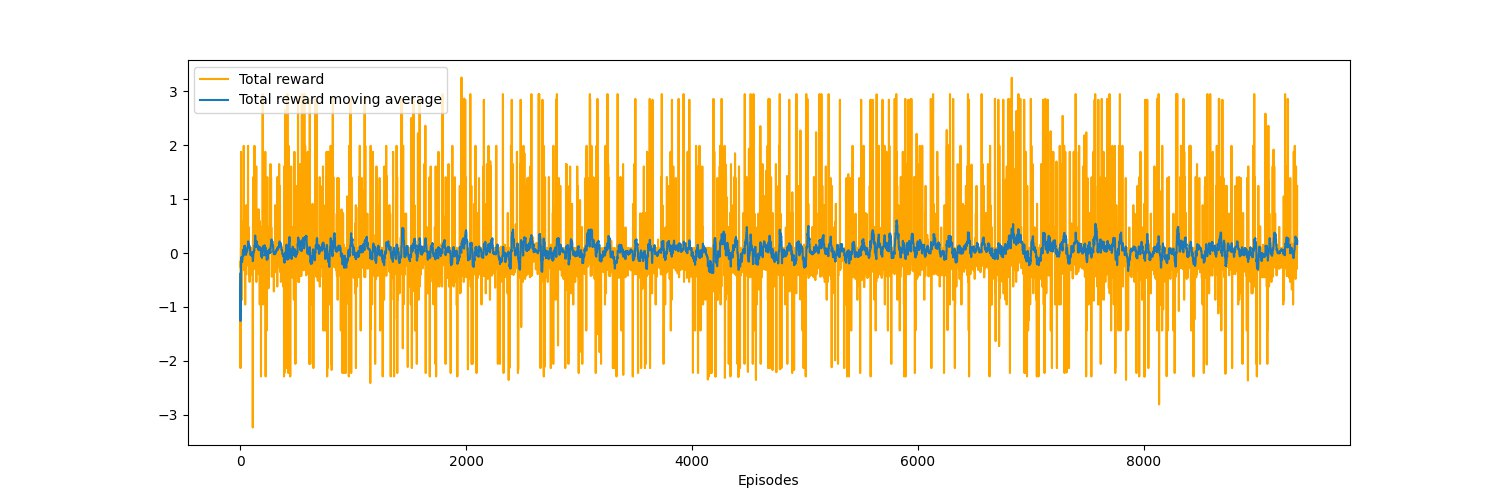

#### 20k episodes

Assuming that the number of training episodes was not sufficient for the model to learn the target policy, a test was conducted with 20,000 episodes, each with a maximum of 20 steps per episode (other parameters were left at default settings).

To train the DDQN on the department's cluster, the training was divided into sessions of 2500 episodes each, saving the weights at the end of each session and then reloading them at the start of the next one: this trick allowed the training to be conducted without the Slurm job running out of memory.

#### Performance Recap

The table below summarizes the results of the experiments conducted: the best outcome in terms of measured metrics was achieved following the test with 20,000 episodes.

| Method                                         | MSE(x$10^3$) $\downarrow$ | PSNR $\uparrow$ | SSIM $\uparrow$ |
|------------------------------------------------|---------------------------|----------------|-----------------|
| **lr 1e-5 (learning rate 1e-5)**               | **9.1822**                | **8.7603**     | **0.1078**      |
| **lr 1e-4 (learning rate 1e-4)**               | **7.7312**                | **9.5924**     | **0.1410**      |
| **argmin**                                     | **16.6831**               | **6.0483**     | **0.0075**      |
| **Environment with the Same Image**            | **14.0121**               | **6.6658**     | **0.0183**      |
| **Reward with MSE**                            | **5.3699**                | **11.1078**    | **0.1847**      |
| **Modified Termination Condition**             | **6.2999**                | **20.1374**    | **0.7912**      |
| **20k Episodes**                               | **1.2215**                | **17.2619**    | **0.7219**      |


## Performance Analysis

To assess the effectiveness of the developed solution, various metrics calculated on the produced image were evaluated in comparison to a reference image. The calculated values were then compared with those obtained using different methods addressing the same problem.

Additionally, the output images were compared with those designated by the dataset creators as ground truth. These reference images were produced not using deep learning, but through various image enhancement methods.

### Qualitative Analysis


Start of Selection
Qualitative analysis involves the assessment of non-quantifiable data, in this case the quality of the enhanced images produced by the DDQN.

Once the network that performed best on the validation set was identified, its effectiveness was tested on the images of the test set, a third set of images separate from the training and validation set.

Five random images from the test set were taken and input into the evaluation DQN. The assessment of the enhanced images produced allowed for a qualitative evaluation of the performance.
End of Selection


In [ ]:
# Perform qualitative analysis by evaluating the model on a set of test episodes.
TEST_Episodes = 5  # Number of test episodes to evaluate
ddqn.epsilon = (
    0  # Disable exploration to use only the best-known strategies during testing.
)
max_test_episode_step = (
    10  # Maximum steps per episode, as used in the referenced study.
)

for e_test in range(TEST_Episodes):
    state = env.reset()  # Reset the environment to start a new episode.
    done = False  # Initialize the 'done' flag to False indicating the episode is not finished.
    step_count = 1  # Initialize step counter to track the number of steps taken.

    while not done:
        action = ddqn.select_action(
            state
        )  # Select the optimal action for the current state.
        new_state, _ = env.step(action)  # Execute the action and get the new state.
        done = ddqn.check_if_done(
            state
        )  # Check if the current state meets the termination criteria.
        state = new_state  # Update the current state to the new state.

        if done or step_count >= max_test_episode_step:
            env.render()  # Render the environment to visualize the current state.
            break  # Exit the loop if the episode is done or max steps are reached.

        step_count += 1  # Increment the step counter.

### Quantitative Analysis


Quantitative analysis is conducted using quantifiable values for evaluation. Specifically, the metrics used for the analysis are MSE, PSNR, and SSIM (already described previously).

The values are calculated in a similar manner to what was done during the validation phase:

* the evaluation DQN is used to enhance the raw image until a stop condition is reached or the maximum number of steps is achieved

* the value for the three metrics is calculated using the obtained image and the reference image

* the first two points are repeated for each image in the test set and subsequently, an average of the values obtained for each metric is calculated

* the average values obtained are used to compare the performance of the model with other solutions that have addressed the same problem


In [ ]:
# Perform quantitative analysis by setting the exploration factor to zero and using fixed maximum steps per episode.
ddqn.epsilon = 0  # Set epsilon to 0 for pure exploitation (no exploration).
max_test_episode_step = 10  # Use the same max steps as in the referenced paper.
total_mse = total_psnr = total_ssim = 0  # Initialize accumulators for the metrics.

for index, (raw_path, ref_path) in enumerate(zip(images_raw_test, images_ref_test)):
    state = env.reset(
        raw_path, ref_path
    )  # Reset environment with new test image paths.
    tot_rewards = 0  # Initialize total rewards for the episode.
    done = False  # Initialize the done flag to False.
    step_count = 1  # Initialize step count.

    # Process each episode until the done flag is True or maximum steps are reached.
    while not done:
        action = ddqn.select_action(
            state
        )  # Select an action based on the current state using the evaluation DQN.
        new_state, reward = env.step(
            action
        )  # Apply the selected action to the environment and receive the new state and reward.
        done = ddqn.check_if_done(
            state
        )  # Check if the current state meets the termination criteria.
        tot_rewards += reward  # Accumulate the reward.
        state = new_state  # Update the state.

        # If the episode is done or maximum steps are reached, compute the metrics.
        if done or step_count >= max_test_episode_step:
            mse = mean_squared_error(
                np.array(env.current_image), np.array(env.reference_image)
            )
            psnr = peak_signal_noise_ratio(
                np.array(env.current_image), np.array(env.reference_image)
            )
            ssim = structural_similarity(
                im1=np.array(env.current_image),
                im2=np.array(env.reference_image),
                channel_axis=2,
            )
            print(
                "episode: {}/{}, steps: {}, episode reward: {}".format(
                    index, len(images_raw_test), step_count, tot_rewards
                )
            )
            total_mse += mse  # Accumulate MSE.
            total_psnr += psnr  # Accumulate PSNR.
            total_ssim += ssim  # Accumulate SSIM.
            break  # Exit the loop after metrics calculation.
        step_count += 1  # Increment the step count.

# Calculate average metrics over all test images.
avg_mse = total_mse / len(images_raw_val)
avg_psnr = total_psnr / len(images_raw_val)
avg_ssim = total_ssim / len(images_raw_val)

# Print the average metrics and hyperparameters.
print(
    "lr: {}, alpha: {}, beta: {}, episode: {} with max steps {}".format(
        learning_rate, alpha, beta, episodes, episode_max_steps
    )
)
print("avg mse: {}, avg_psnr: {}, avg ssim: {}".format(avg_mse, avg_psnr, avg_ssim))

## Comparison with other solutions


The following table shows the results obtained on the test set of various models proposed by papers that address the same problem.

The values for the model implemented in this paper were chosen based on those obtained during testing from the model that showed the best performance during validation.

Method         | MSE(x$10^3$) $\downarrow$ | PSNR $\uparrow$ | SSIM $\uparrow$
---            | ---    | ---     | ---
WaterNet       | 0.7976 | 19.1130 | 0.7971
Water CycleGAN | 1.7298 | 15.7508 | 0.5210
Dense GAN      | 1.2152 | 17.28.43| 0.4426
**DDQN 20k episodes** | **2.1216** | **15.4687** | **0.6281**

Despite the model achieving a commendable result on the validation set, the performance on the test set is less interesting. The model fails to generalize (overfitting) and, although the result might also depend on the too small size of the training set, it is possible that increasing the number of training episodes could lead to better performance.
